# Pre-processing of data for the classification task and clustering task from our wild coffee trees and Madaclim climate/environmental features dataset

Continuation from the `data_extraction.ipynb`  where the data for the 51 species of wild coffea trees was extracted.

We need to perform the following tasks:

- Validate our categorical encoding
- LabelEncoding for our target variable
- Separate categorical and continuous features
- Impute missing data in continuous features
- Perform transformation of continuous features if needed
- Perform feature selection based on several strategies for both our classification and clustering tasks
- Select best feature selection algorithms
- Train several classfication models and evaluate their performance
- Train several clustering models and evaluate their performance
- Evaluate the performance the classifier on a validation set

In [1]:
from pathlib import Path
import pickle
from typing import Union, List, Tuple, Dict, Optional
import re

from py_madaclim.info import MadaclimLayers
from py_madaclim.raster_manipulation import MadaclimCollection, MadaclimPoint, MadaclimRasters

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import numpy as np
from scipy.stats import skew
from statsmodels.stats.outliers_influence import variance_inflation_factor

from rasterio import plot
import rasterio
import geopandas as gpd

from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA



In [2]:
# Instantiate a metadata layers object
mada_info = MadaclimLayers()

In [3]:
# From data_exploration.ipynb
def plot_feats_distributions(data, feats: Union[list, str], main_title: str, nrows: int, ncols: int, figsize: tuple=(10, 10), barcolor: str="blue"):
    """Display the data distributions as histograms for the selected features.

    Args:
        data (df): dataframe containing the data with the features of interest
        feats (list): List of the features name
        nrows (int): Number of rows of the multi histrogram plot
        ncols (int): Number of columns of the multi histrogram plot
        figsize (tuple): Size of the figure
    Returns:
        None
    
    """
    # Convert 
    if isinstance(feats, str):
        feats = [feats]

    # Plot a single feature
    if len(feats) == 1:
        if nrows > 1 or ncols > 1:
            raise ValueError("'nrows' and 'ncols' must be == 1 for a single feature to plot")
        
        # Setup fig ax
        fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

        # Plot hist + black KDE
        sns.histplot(
            data=data[feats].iloc[:, 0],
            color=barcolor,
            ax=ax,
            kde=True, stat="count",
            line_kws={"linestyle" : "--"},
            legend=False
        )
        ax.set_xlabel("")
        ax.lines[0].set_color("black")
        ax.set_title(f"{feats[0]}", pad=8, weight="bold", size=8)
    
    # Plot with multiple features
    else:
        # shorten labels if descriptive
        if all([len(label.split("_")) > 3 for label in feats]):
            feats_labels = ["_".join(label.split("_", 3)[:3]) for label in feats]
        else:
            feats_labels = feats

        # Setup fig and axes canvas
        fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
        axes = axes.ravel()

        # Plot histograms with black KDE line for each feature
        for i, feat in enumerate(feats):
            sns.histplot(
                data=data,
                x=feat,
                color=barcolor,
                ax=axes[i],
                kde=True, stat="count",
                line_kws={"linestyle" : "--"}
            )
            axes[i].set_xlabel("")
            axes[i].lines[0].set_color("black")
            axes[i].set_title(f"{feats_labels[i]}", pad=8, weight="bold", size=8)
        
    fig.suptitle(f"{main_title}\n", weight="bold", size=15)  
    fig.tight_layout()

## Import the extracted data from our wild coffee tree dataset

### Load the pickled mada_collection instance and remove unneeded information

In [4]:
data_dir = Path.cwd() / "data"

with open(data_dir / "pickled/coffea_collection.pkl", "rb") as pkl_f:
    coffea_collection = pickle.load(pkl_f)

In [5]:
len(coffea_collection.all_points)

51

In [6]:
coffea_collection.all_points[0]

MadaclimPoint(
	specimen_id = ABA,
	source_crs = 4326,
	longitude = 46.8624,
	latitude = -24.7541,
	mada_geom_point = POINT (688328.2403248843 7260998.022932809),
	len(sampled_layers) = 79 layer(s),
	len(nodata_layers) = None (0 layers),
	is_categorical_encoded = True,
	species_name = C.abbayesii,
	pop_code = A601,
	gbs_seq = C_abbayesii_A601,
	botanical_series = Millotii,
	genome_size_2C_pg = 1.25,
	gdf.shape = (1, 171)
)

In [7]:
print(coffea_collection.is_categorical_encoded)

True


Copy the gdf to avoid modifying the mada_collection's gdf attribute inplace

In [8]:
# Copy of whole gdf
gdf_coffea = coffea_collection.gdf.copy()
gdf_coffea.iloc[:5, :13]    # Common cols

,specimen_id,source_crs,longitude,latitude,mada_geom_point,sampled_layers,nodata_layers,is_categorical_encoded,species_name,pop_code,gbs_seq,botanical_series,genome_size_2C_pg
0,ABA,4326,46.862400,-24.754100,POINT (688328.240 7260998.023),79,0,True,C.abbayesii,A601,C_abbayesii_A601,Millotii,1.25
1,AMB,4326,48.943300,-18.452200,POINT (916635.952 7955240.629),79,0,True,C.ambodirianenis,A572,C_ambodirianensis_A572,Millotii,1.27
2,AMBON,4326,46.419806,-15.574583,POINT (652237.905 8277614.406),79,1,True,C.ambongensis,BR071,C_ambongensis,Baracoffea,1.16
3,ANK1,4326,49.543300,-12.949100,POINT (993250.150 8564104.062),79,0,True,C.ankaranensis,A525,C_ankaranensis_A525,Multiflorae,1.17
4,ANK2,4326,49.543300,-12.849100,POINT (993446.882 8575194.181),79,0,True,C.ankaranensis,A808,NaN,Multiflorae,1.17


Remove uninformative columns

In [9]:
# Drop uninformative cols: object states + ID and sequencing state
cols_to_drop = ["source_crs", "sampled_layers", "nodata_layers", "is_categorical_encoded", "pop_code", "gbs_seq"]
gdf_coffea = gdf_coffea.drop(columns=cols_to_drop)
gdf_coffea.head()


,specimen_id,longitude,latitude,mada_geom_point,species_name,botanical_series,genome_size_2C_pg,clim_1_tmin1_Monthly minimum temperature - January (°C x 10),clim_2_tmin2_Monthly minimum temperature - February (°C x 10),clim_3_tmin3_Monthly minimum temperature - March (°C x 10),...,env_78_wat_Watersheds_RetDisp_Mahavavy,env_78_wat_Watersheds_RetDisp_Manampatrana,env_78_wat_Watersheds_RetDisp_Mananara_du_Sud,env_78_wat_Watersheds_RetDisp_Mandrare,env_78_wat_Watersheds_RetDisp_Mangoky,env_78_wat_Watersheds_RetDisp_Mangoro,env_78_wat_Watersheds_RetDisp_Onilahy,env_78_wat_Watersheds_RetDisp_Sambirano,env_78_wat_Watersheds_RetDisp_Tsiribihina,env_78_wat_Watersheds__nodata
0,ABA,46.862400,-24.754100,POINT (688328.240 7260998.023),C.abbayesii,Millotii,1.25,155,195,188,...,0,0,0,0,0,0,0,0,0,0
1,AMB,48.943300,-18.452200,POINT (916635.952 7955240.629),C.ambodirianenis,Millotii,1.27,157,203,199,...,0,0,0,0,0,0,0,0,0,0
2,AMBON,46.419806,-15.574583,POINT (652237.905 8277614.406),C.ambongensis,Baracoffea,1.16,222,236,238,...,0,0,0,0,0,0,0,0,0,0
3,ANK1,49.543300,-12.949100,POINT (993250.150 8564104.062),C.ankaranensis,Multiflorae,1.17,206,228,227,...,0,0,0,0,0,0,0,0,0,0
4,ANK2,49.543300,-12.849100,POINT (993446.882 8575194.181),C.ankaranensis,Multiflorae,1.17,203,226,224,...,0,0,0,0,0,0,0,0,0,0


In [10]:

mada_rasters = MadaclimRasters(data_dir / "madaclim_current.tif", data_dir / "madaclim_enviro.tif")
mada_info.clim_raster = mada_rasters.clim_raster
mada_info.env_raster = mada_rasters.env_raster
test = MadaclimPoint("test", longitude=45.0667, latitude=-12.7167)
test.gdf

,specimen_id,source_crs,longitude,latitude,mada_geom_point,sampled_layers,nodata_layers,is_categorical_encoded
0,test,4326,45.0667,-12.7167,POINT (507241.157 8594192.091),None,None,False


In [11]:
test.sample_from_rasters(mada_rasters.clim_raster, mada_rasters.env_raster)


######################################## Extracting data for: test ########################################

Sampling 70 layer(s) from madaclim_current.tif (geoclim_type=clim)...


Extracting layer 44: Mean temperature of wettest quarter:  61%|██████▏   | layer 43/70 [Time remaining: 00:00]    

Extracting layer 70: Number of dry months in the year:  100%|██████████| layer 70/70 [Time remaining: 00:00]                                              



Sampling 9 layer(s) from madaclim_enviro.tif (geoclim_type=env)...


Extracting layer 79: Percentage of forest cover in 1 km by 1 km grid cells:  100%|██████████| layer 9/9 [Time remaining: 00:00]   


BEWARE! 5 layer(s) contain a nodata value at the specimen location

Finished raster sampling operation in 0.39 seconds.



In [12]:
test.species_name = "humb"

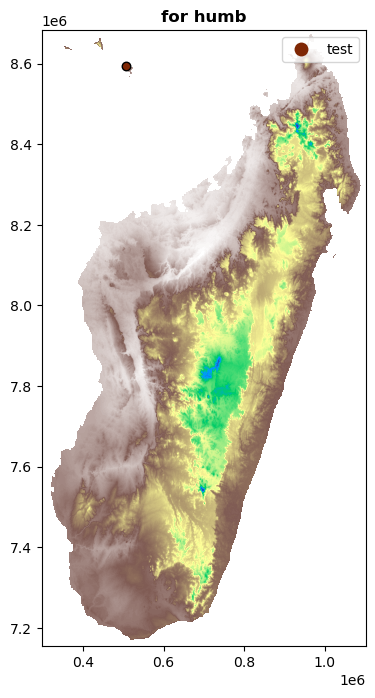

In [13]:
with rasterio.open(mada_rasters.clim_raster) as clim_rast:
    band_num = mada_info.get_bandnums_from_layers(mada_info.get_layers_labels(37))[0]
    band_data = clim_rast.read(band_num, masked=True)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax = plot.show(
        source=band_data, 
        transform=clim_rast.transform, 
        cmap="terrain", 
        ax=ax, 
        title=f"for {test.gdf['species_name'].values[0]}")

    test.gdf.plot(column="specimen_id", ax=ax, cmap="Oranges_r", markersize=150, marker=".", legend=True, edgecolor="k")

In [14]:
test.nodata_layers

['layer_75', 'layer_76', 'layer_77', 'layer_78', 'layer_79']

In [15]:
try:
    test_mac = MadaclimPoint("mac_test", longitude=57.43, latitude=-20.378, species_name="macrocarpa")
except Exception as e:
    print(e)

longitude=57.43 is out of bounds of the Madaclim rasters' for mac_test.
Longitude must fall between 42.986762 and 50.978377 (according to `source_crs`).


In [16]:
gdf_coffea[gdf_coffea["botanical_series"] == "Mauritianae_Humblotianae"]

,specimen_id,longitude,latitude,mada_geom_point,species_name,botanical_series,genome_size_2C_pg,clim_1_tmin1_Monthly minimum temperature - January (°C x 10),clim_2_tmin2_Monthly minimum temperature - February (°C x 10),clim_3_tmin3_Monthly minimum temperature - March (°C x 10),...,env_78_wat_Watersheds_RetDisp_Mahavavy,env_78_wat_Watersheds_RetDisp_Manampatrana,env_78_wat_Watersheds_RetDisp_Mananara_du_Sud,env_78_wat_Watersheds_RetDisp_Mandrare,env_78_wat_Watersheds_RetDisp_Mangoky,env_78_wat_Watersheds_RetDisp_Mangoro,env_78_wat_Watersheds_RetDisp_Onilahy,env_78_wat_Watersheds_RetDisp_Sambirano,env_78_wat_Watersheds_RetDisp_Tsiribihina,env_78_wat_Watersheds__nodata
21,HUMB,45.066667,-12.716667,POINT (507237.575 8594195.742),C.humblotiana,Mauritianae_Humblotianae,0.97,197,218,218,...,0,0,0,0,0,0,0,0,0,1


## Extract the botanical series classification label

### Botanical_series label encoding using LabelEncoder

We have 2 external categorical features outside of the Madaclim DB which is specific to our dataset (see the additional attributes for each MadaclimPoint):

-  species_name
- botanical_series

In [17]:
print(f'{len(gdf_coffea["species_name"].unique())} diff species_name out of {len(gdf_coffea)} specimens')

45 diff species_name out of 51 specimens


`species_name` is mostly a unique field for each object so we will not use it in our models but just keep it for informational purposes

In botanical nomenclature, a series is a rank between a subgenus and a species. It's one of the additional ranks that can be used to categorize and organize species based on certain shared characteristics. The series level of classification isn't always used; its application depends on the specific practices of the scientists studying a particular group of organisms.

In [18]:
# botanical_series distribution in our dataset
y_label = "botanical_series"
gdf_coffea[y_label].value_counts()

Multiflorae                 19
Subterminales               10
Millotii                     7
Baracoffea                   5
Garcinioides                 4
Verae                        4
Mauritianae_Humblotianae     1
Name: botanical_series, dtype: int64

I permitted myself to change the Humb and Mau from the original data to a common `Mauritianae_Humblotianae` class based on this paper: https://www.sciencedirect.com/book/9780124095175/coffee-in-health-and-disease-prevention

In [19]:
print(f'There is/are {gdf_coffea["botanical_series"].isnull().sum()} null values for "botanical_series"')

There is/are 1 null values for "botanical_series"


Convert `np.nan` to str type with 'Unknown/Undetermined' label

In [20]:
gdf_coffea.loc[gdf_coffea["botanical_series"].isnull(), "botanical_series"] = "Unknown/Undetermined"

In [21]:
gdf_coffea[y_label].value_counts()

Multiflorae                 19
Subterminales               10
Millotii                     7
Baracoffea                   5
Garcinioides                 4
Verae                        4
Mauritianae_Humblotianae     1
Unknown/Undetermined         1
Name: botanical_series, dtype: int64

In [22]:
# Label encoding of botanical_series classes
le = LabelEncoder()
y = le.fit_transform(gdf_coffea[y_label])
print(f"There are {len(le.classes_)} unique botanical_series that have been encoded")

There are 8 unique botanical_series that have been encoded


In [23]:
# Remove y from whole df
gdf_coffea = gdf_coffea.drop(columns=y_label)

## Perform missing data imputation

### Split categorical and numerical features

In [24]:
# Define common cols to keep
common_cols = list(gdf_coffea.columns[:5])
common_cols

['specimen_id', 'longitude', 'latitude', 'mada_geom_point', 'species_name']

In [25]:
# Extract categorical features with MadaCollection.encoded_categ_labels attr
features_categ = coffea_collection.encoded_categ_labels
features_categ[:5]

['env_75_geo_Rock types_Alluvial_&_Lake_deposits',
 'env_75_geo_Rock types_Basement_Rocks_(Ign_&_Met)',
 'env_75_geo_Rock types_Lavas_(including_Basalts_&_Gabbros)',
 'env_75_geo_Rock types_Mangrove_Swamp',
 'env_75_geo_Rock types_Marble_(Cipolin)']

In [26]:
# Extract continuous features
features_cont = list(gdf_coffea.drop(columns=features_categ + common_cols).columns)
features_cont[:5]

['genome_size_2C_pg',
 'clim_1_tmin1_Monthly minimum temperature - January (°C x 10)',
 'clim_2_tmin2_Monthly minimum temperature - February (°C x 10)',
 'clim_3_tmin3_Monthly minimum temperature - March (°C x 10)',
 'clim_4_tmin4_Monthly minimum temperature - April (°C x 10)']

### Categorical feature missing data

Recap on the missing data with some missing values in both categorical and continous features

In [27]:
# Check for additionnal nodata categories
for specimen, layers in coffea_collection.encoded_categ_layers.items():
    for layer, value in layers.items():
        if "__nodata" in layer:
            if value > 0:
                print(specimen, layer, value)

AMBON env_76_soi_Soil types__nodata 1
HUMB env_75_geo_Rock types__nodata 1
HUMB env_76_soi_Soil types__nodata 1
HUMB env_77_veg_Vegetation types__nodata 1
HUMB env_78_wat_Watersheds__nodata 1
RES1 env_75_geo_Rock types__nodata 1
SAHA env_75_geo_Rock types__nodata 1


We keep understandability high, preserve our data (no dropping of features or columns).

However, we don't know the type of 'missingness', but since the proportion of missing data per features is relatively small it will not matter that much.

In [28]:
# Amount of nodata values in categorical features
gdf_coffea[[feat for feat in features_categ if "nodata" in feat]].sum()

env_75_geo_Rock types__nodata          3
env_76_soi_Soil types__nodata          2
env_77_veg_Vegetation types__nodata    1
env_78_wat_Watersheds__nodata          1
dtype: int64

### Continuous features missing data imputation

In [29]:
# Total of missing data points for continuous features
features_cont_missing = list(gdf_coffea[features_cont].isnull().sum()[gdf_coffea[features_cont].isnull().sum() > 0].index)
features_cont_missing


['genome_size_2C_pg',
 'env_79_forcov_Percentage of forest cover in 1 km by 1 km grid cells (%)']

In [30]:
# specimen_id for objects with null vals in continuous feats
gdf_coffea[["specimen_id"] + features_cont_missing][gdf_coffea[features_cont_missing].isnull().any(axis=1)]

,specimen_id,genome_size_2C_pg,env_79_forcov_Percentage of forest cover in 1 km by 1 km grid cells (%)
21,HUMB,0.97,NaN
48,HBERT,NaN,68.0
49,LABAT,NaN,28.0
50,LIAUD,NaN,0.0


#### Compare simple Mean/Median Imputer vs KNN-Imputation with optimized hyperparameters

Steps:

1. Impute the missing numerical features using 2 approaches mean and KNN (multiple K's and weight metrics) for numerical data
2. Evaluate the mean-imputed vs. KNN imputed on a botanical_series classification with multiple classifiers

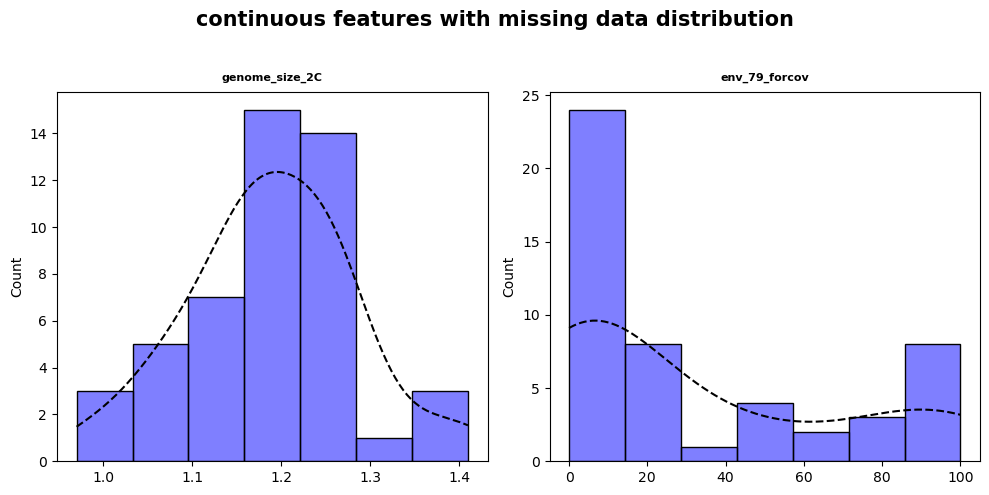

In [31]:
plot_feats_distributions(
    data=gdf_coffea,
    feats=features_cont_missing,
    main_title="continuous features with missing data distribution",
    nrows=1,
    ncols=2,
    figsize=(10, 5)
)

Looking at the distributions, we will first use a simpler imputation technique:
1. Mean for genome size because it appears as a normal distributed feature
2. Median for forcov because of it's right skewed distribution

In [32]:

mean_genome_size = gdf_coffea["genome_size_2C_pg"].mean()    # features_cont_missing[0]
median_forcov = gdf_coffea["env_79_forcov_Percentage of forest cover in 1 km by 1 km grid cells (%)"].median() # features_cont_missing[1]
print(f"{mean_genome_size=}")
print(f"{median_forcov=}")


mean_genome_size=1.1891666666666667
median_forcov=16.5


Build a pipeline that will impute our data with different k values and weight option, run a classification model for each K and calculate the accuracy score over 3repeated stratified k-fold cross-validation.

We will then compare this KNN imputation strategy with the Mean/Median SimpleImputer

In [33]:
# Get our continuous data with missing values
X = pd.DataFrame(gdf_coffea[features_cont])
X.head()

,genome_size_2C_pg,clim_1_tmin1_Monthly minimum temperature - January (°C x 10),clim_2_tmin2_Monthly minimum temperature - February (°C x 10),clim_3_tmin3_Monthly minimum temperature - March (°C x 10),clim_4_tmin4_Monthly minimum temperature - April (°C x 10),clim_5_tmin5_Monthly minimum temperature - May (°C x 10),clim_6_tmin6_Monthly minimum temperature - June (°C x 10),clim_7_tmin7_Monthly minimum temperature - July (°C x 10),clim_8_tmin8_Monthly minimum temperature - August (°C x 10),clim_9_tmin9_Monthly minimum temperature - September (°C x 10),...,clim_66_pet11_Monthly potential evapotranspiration from the Thornthwaite equation - November (mm.month-1),clim_67_pet12_Monthly potential evapotranspiration from the Thornthwaite equation - December (mm.month-1),clim_68_pet_Annual potential evapotranspiration from the Thornthwaite equation (mm),clim_69_cwd_Annual climatic water deficit (mm),clim_70_ndm_Number of dry months in the year (months.year-1),env_71_alt_Altitude (meters),env_72_slo_Slope (degrees),env_73_asp_Aspect; clockwise from North (degrees),"env_74_solrad_Solar radiation; computed from altitude, slope and aspect (Wh.m-2.day-1)",env_79_forcov_Percentage of forest cover in 1 km by 1 km grid cells (%)
0,1.25,155,195,188,171,136,122,120,124,138,...,110,123,1022,77,4,350,14,167,6475,100.0
1,1.27,157,203,199,185,164,149,142,139,144,...,109,121,1041,16,1,567,8,27,7894,65.0
2,1.16,222,236,238,235,217,199,191,193,205,...,164,156,1709,849,8,24,1,304,7784,44.0
3,1.17,206,228,227,224,211,192,186,188,194,...,147,146,1482,501,8,158,12,42,7979,20.0
4,1.17,203,226,224,222,209,190,184,186,192,...,141,141,1431,487,8,137,6,355,8056,0.0


Our botanical_series 'y' present imbalance in classes proportion

In [34]:
np.bincount(y)

array([ 5,  4,  1,  7, 19, 10,  1,  4])

In [35]:
le.classes_

array(['Baracoffea', 'Garcinioides', 'Mauritianae_Humblotianae',
       'Millotii', 'Multiflorae', 'Subterminales', 'Unknown/Undetermined',
       'Verae'], dtype=object)

Text(0.5, 1.0, 'Class imbalance for botanical-series')

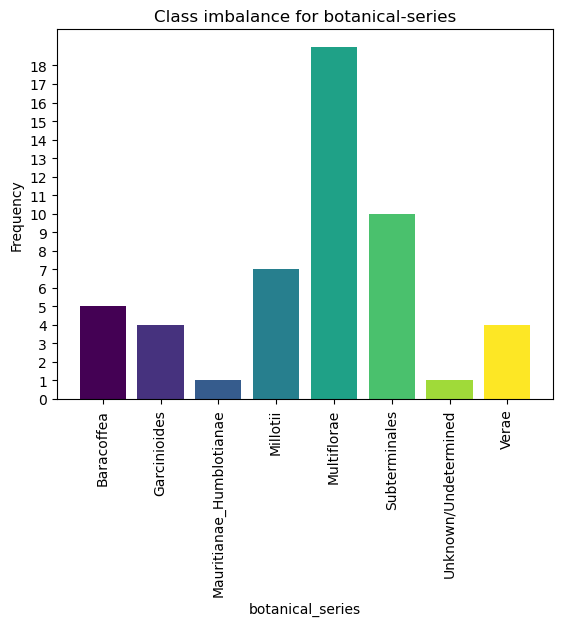

In [36]:
# We already label-encoded our targets for botanical_series
plt.bar(x=le.classes_, height=np.bincount(y), color=plt.cm.viridis(np.linspace(0, 1, len(le.classes_))))
plt.xlabel(y_label)
plt.xticks(rotation=90)
plt.ylabel("Frequency")
plt.yticks(range(0, np.max(np.bincount(y)), 1))
plt.title("Class imbalance for botanical-series")

We will need to use Stratified KFold CV to ensure correct class representation in our training sets for each folds (regular fold is based on a random choice for class objects and does not account necessarily for imbalance). 

However, since we have lowly represented class (Maur/Humb botanical series) with only 2 objects we might have to choose only k=2 folds unless we get more data

In [37]:
def plot_cv_indices(cv, X, y, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=plt.cm.coolwarm,
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data classes at the end
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap="tab10"
    )

    # Formatting
    yticklabels = list(range(n_splits)) + ["class"]
    ax.set(
        yticks=np.arange(n_splits + 1) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 2.2, -0.2],
        xlim=[0, len(X)],
    )
    ax.set_title(f"{cv}")
    return ax

<Axes: title={'center': 'KFold(n_splits=2, random_state=None, shuffle=False)'}, xlabel='Sample index', ylabel='CV iteration'>

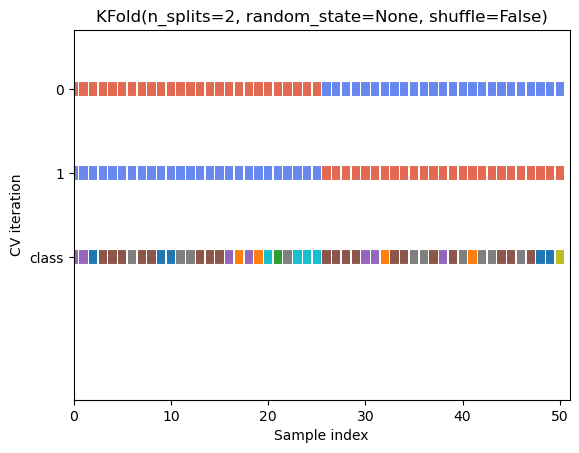

In [38]:
# Regular KFold
fig, ax = plt.subplots()
n_splits = 2
cv = KFold(n_splits=n_splits)
plot_cv_indices(cv, X, y, ax, n_splits)

/home/local/USHERBROOKE/lals2906/anaconda3/envs/aphylo_cm/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


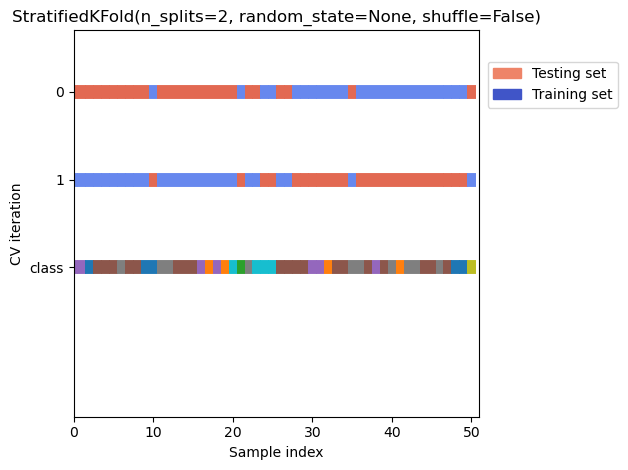

In [39]:
fig, ax = plt.subplots()
cv = StratifiedKFold(n_splits=n_splits)
plot_cv_indices(cv, X, y, ax, n_splits)
ax.legend(
        [Patch(color=plt.cm.coolwarm(0.8)), Patch(color=plt.cm.coolwarm(0.02))],
        ["Testing set", "Training set"],
        loc=(1.02, 0.8),
)
    # Make the legend fit
plt.tight_layout()

Not a huge difference, but if we get more data in the future we could increase the CV folds and thus StratifiedKFold will be even more beneficial to avoid overfitting and poor performance

In [40]:
# Generate k and weights combinations
k_range = range(3, 12, 2)
weights_range = ["uniform", "distance"]
knn_params = []
for k in k_range:
    for w in weights_range:
        knn_params.append({"n_neighbors": k, "weights": w})

print(f"total hyperparam combinations: {len(knn_params)}")
knn_params

total hyperparam combinations: 10


[{'n_neighbors': 3, 'weights': 'uniform'},
 {'n_neighbors': 3, 'weights': 'distance'},
 {'n_neighbors': 5, 'weights': 'uniform'},
 {'n_neighbors': 5, 'weights': 'distance'},
 {'n_neighbors': 7, 'weights': 'uniform'},
 {'n_neighbors': 7, 'weights': 'distance'},
 {'n_neighbors': 9, 'weights': 'uniform'},
 {'n_neighbors': 9, 'weights': 'distance'},
 {'n_neighbors': 11, 'weights': 'uniform'},
 {'n_neighbors': 11, 'weights': 'distance'}]

Since KNN uses an euclidean distance metric, we need to scale all the numerical features first using StandardScaler to put all the features on the same scale.

We get z-scores with mean=0 and variance in the same order for all objects

In [41]:
# Imputation with a GridSearch-ish approach using the RFC accuracy metric to compare between hyperparams
results = []
n_splits = 2
n_reps = 15
for params in knn_params:
    pipeline = Pipeline(steps=[
        ("scaler", StandardScaler()),
        ("imputer", KNNImputer(**params)), 
        ("classifier", RandomForestClassifier())
    ])
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_reps, random_state=42)   # Keep same randomness accross splits
    scores = cross_val_score(pipeline, X, y, scoring="accuracy", cv=cv)
    results.append((params, scores))
    print(f"RFC({params}): mean={scores.mean()}, std={scores.std()}")

/home/local/USHERBROOKE/lals2906/anaconda3/envs/aphylo_cm/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/home/local/USHERBROOKE/lals2906/anaconda3/envs/aphylo_cm/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/home/local/USHERBROOKE/lals2906/anaconda3/envs/aphylo_cm/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


/home/local/USHERBROOKE/lals2906/anaconda3/envs/aphylo_cm/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/home/local/USHERBROOKE/lals2906/anaconda3/envs/aphylo_cm/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/home/local/USHERBROOKE/lals2906/anaconda3/envs/aphylo_cm/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/home/local/USHERBROOKE/lals2906/anaconda3/envs/aphylo_cm/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/home/local/USHERBROOKE/lals2906/anaconda3/envs/

RFC({'n_neighbors': 3, 'weights': 'uniform'}): mean=0.41548717948717956, std=0.07082041998545688


/home/local/USHERBROOKE/lals2906/anaconda3/envs/aphylo_cm/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/home/local/USHERBROOKE/lals2906/anaconda3/envs/aphylo_cm/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/home/local/USHERBROOKE/lals2906/anaconda3/envs/aphylo_cm/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/home/local/USHERBROOKE/lals2906/anaconda3/envs/aphylo_cm/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/home/local/USHERBROOKE/lals2906/anaconda3/envs/

RFC({'n_neighbors': 3, 'weights': 'distance'}): mean=0.42461538461538473, std=0.07419575366510496


/home/local/USHERBROOKE/lals2906/anaconda3/envs/aphylo_cm/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/home/local/USHERBROOKE/lals2906/anaconda3/envs/aphylo_cm/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/home/local/USHERBROOKE/lals2906/anaconda3/envs/aphylo_cm/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/home/local/USHERBROOKE/lals2906/anaconda3/envs/aphylo_cm/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/home/local/USHERBROOKE/lals2906/anaconda3/envs/

RFC({'n_neighbors': 5, 'weights': 'uniform'}): mean=0.4142051282051282, std=0.06133258296428047


/home/local/USHERBROOKE/lals2906/anaconda3/envs/aphylo_cm/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/home/local/USHERBROOKE/lals2906/anaconda3/envs/aphylo_cm/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/home/local/USHERBROOKE/lals2906/anaconda3/envs/aphylo_cm/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/home/local/USHERBROOKE/lals2906/anaconda3/envs/aphylo_cm/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/home/local/USHERBROOKE/lals2906/anaconda3/envs/

RFC({'n_neighbors': 5, 'weights': 'distance'}): mean=0.4052307692307693, std=0.05982696943845099


/home/local/USHERBROOKE/lals2906/anaconda3/envs/aphylo_cm/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/home/local/USHERBROOKE/lals2906/anaconda3/envs/aphylo_cm/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/home/local/USHERBROOKE/lals2906/anaconda3/envs/aphylo_cm/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/home/local/USHERBROOKE/lals2906/anaconda3/envs/aphylo_cm/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/home/local/USHERBROOKE/lals2906/anaconda3/envs/

RFC({'n_neighbors': 7, 'weights': 'uniform'}): mean=0.4142051282051282, std=0.04912437756087024


/home/local/USHERBROOKE/lals2906/anaconda3/envs/aphylo_cm/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/home/local/USHERBROOKE/lals2906/anaconda3/envs/aphylo_cm/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/home/local/USHERBROOKE/lals2906/anaconda3/envs/aphylo_cm/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/home/local/USHERBROOKE/lals2906/anaconda3/envs/aphylo_cm/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/home/local/USHERBROOKE/lals2906/anaconda3/envs/

RFC({'n_neighbors': 7, 'weights': 'distance'}): mean=0.4141025641025641, std=0.0657087991469833


/home/local/USHERBROOKE/lals2906/anaconda3/envs/aphylo_cm/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/home/local/USHERBROOKE/lals2906/anaconda3/envs/aphylo_cm/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/home/local/USHERBROOKE/lals2906/anaconda3/envs/aphylo_cm/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/home/local/USHERBROOKE/lals2906/anaconda3/envs/aphylo_cm/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/home/local/USHERBROOKE/lals2906/anaconda3/envs/

RFC({'n_neighbors': 9, 'weights': 'uniform'}): mean=0.40507692307692317, std=0.066289842323438


/home/local/USHERBROOKE/lals2906/anaconda3/envs/aphylo_cm/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/home/local/USHERBROOKE/lals2906/anaconda3/envs/aphylo_cm/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/home/local/USHERBROOKE/lals2906/anaconda3/envs/aphylo_cm/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/home/local/USHERBROOKE/lals2906/anaconda3/envs/aphylo_cm/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/home/local/USHERBROOKE/lals2906/anaconda3/envs/

RFC({'n_neighbors': 9, 'weights': 'distance'}): mean=0.42312820512820515, std=0.06625690640442955


/home/local/USHERBROOKE/lals2906/anaconda3/envs/aphylo_cm/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/home/local/USHERBROOKE/lals2906/anaconda3/envs/aphylo_cm/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/home/local/USHERBROOKE/lals2906/anaconda3/envs/aphylo_cm/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/home/local/USHERBROOKE/lals2906/anaconda3/envs/aphylo_cm/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/home/local/USHERBROOKE/lals2906/anaconda3/envs/

RFC({'n_neighbors': 11, 'weights': 'uniform'}): mean=0.416974358974359, std=0.057737053872492346


/home/local/USHERBROOKE/lals2906/anaconda3/envs/aphylo_cm/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/home/local/USHERBROOKE/lals2906/anaconda3/envs/aphylo_cm/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/home/local/USHERBROOKE/lals2906/anaconda3/envs/aphylo_cm/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/home/local/USHERBROOKE/lals2906/anaconda3/envs/aphylo_cm/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/home/local/USHERBROOKE/lals2906/anaconda3/envs/

RFC({'n_neighbors': 11, 'weights': 'distance'}): mean=0.41276923076923083, std=0.07265182701379101


/home/local/USHERBROOKE/lals2906/anaconda3/envs/aphylo_cm/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


In [42]:
# Now adding the simpleimputer strategy (mean/median) to the results
mean_imputer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean"))
])

# Median imputer
median_imputer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

# Combine imputers on each specific cols
imputers = ColumnTransformer(
    transformers=[
        ("mean_imputer", mean_imputer, [X.columns.get_loc(features_cont_missing[0])]),    # Genome size
        ("median_imputer", median_imputer, [X.columns.get_loc(features_cont_missing[1])])    # forcov
    ])

# Create final pipeline with the scaler and classifier
pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("imputers", imputers),
    ("classifier", RandomForestClassifier())
])
# Perform cross validation with same param and append scores to result
cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_reps, random_state=42)   # Keep same randomness accross splits
scores = cross_val_score(pipeline, X, y, scoring="accuracy", cv=cv)
results.append(("MeanMedian_imputer", scores))
print(f"RFC(MeanMedian_imputer): mean={scores.mean()}, std={scores.std()}")

/home/local/USHERBROOKE/lals2906/anaconda3/envs/aphylo_cm/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/home/local/USHERBROOKE/lals2906/anaconda3/envs/aphylo_cm/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/home/local/USHERBROOKE/lals2906/anaconda3/envs/aphylo_cm/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/home/local/USHERBROOKE/lals2906/anaconda3/envs/aphylo_cm/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/home/local/USHERBROOKE/lals2906/anaconda3/envs/

RFC(MeanMedian_imputer): mean=0.42179487179487174, std=0.08365900858420003


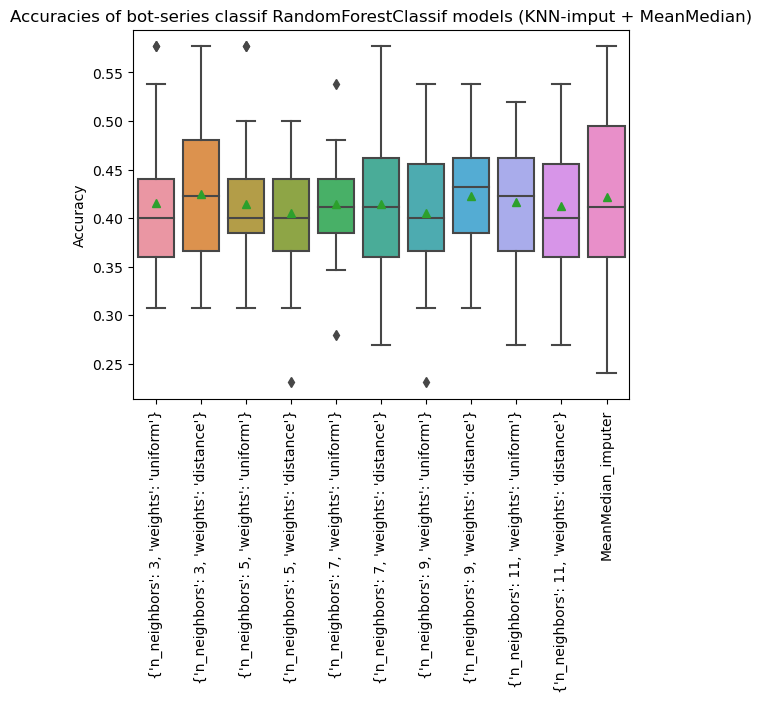

In [43]:
# Plot both approaches and compare
g = sns.boxplot([res[1] for res in results], showmeans=True)
g.set_xticklabels(knn_params+["MeanMedian_imputer"], rotation=90)
g.set_ylabel("Accuracy")
g.set_title(f"Accuracies of bot-series classif RandomForestClassif models (KNN-imput + MeanMedian)")
plt.show()

In [44]:
def extract_best_params_for_knnimp(cv_results: List[Tuple[Dict[str, Union[int, str]], np.array]], lambdas: Union[List, np.array]=[0, 0.5, 1, 2]) -> Dict:
    """Extract the best hyperparameters for KNN Imputation.

    This function extracts the best hyperparameters based on cross-validation scores 
    for KNN Imputation. It uses a weighted approach where a lambda factor is used to
    balance the mean and standard deviation of the scores. The function iterates over 
    different lambda values and for each lambda, it computes a score for each set of
    hyperparameters. It then selects the hyperparameters with the highest score.

    Args:
        cv_results: A list of tuples where each tuple contains a dictionary of hyperparameters 
                    and a numpy array of the corresponding cross-validation scores.
        lambdas: A list or numpy array of lambda factors used for weighting the mean and
                 standard deviation of the cross-validation scores. Defaults to [0, 0.5, 1, 2].

    Returns:
        A dictionary where the keys are lambda values and the values are the best set of 
        hyperparameters for each lambda value.

    """
    lambda_best_params_dict = {}  # Initialize an empty dictionary to store best hyperparameters for each lambda

    for lambda_ in lambdas:  # Loop over each lambda value
        best_params = None  # Initialize variable for the best parameters
        best_params_score = -np.inf  # Initialize variable for the score of the best parameters

        for params, scores in cv_results:  # Loop over each set of hyperparameters and their corresponding scores
            current_params_mean = np.mean(scores)  # Compute mean of current scores
            current_params_std = np.std(scores)  # Compute standard deviation of current scores
            # Compute score of current parameters by subtracting lambda times std from mean
            current_params_score = current_params_mean - (lambda_ * current_params_std)

            if current_params_score > best_params_score:  # If the score of the current parameters is higher than the best score found so far
                best_params = params  # Update the best parameters
                best_params_score = current_params_score  # Update the best score
        
        # Store the best parameters for the current lambda in the dictionary
        lambda_best_params_dict[lambda_] = best_params
        print(f"for lambda={lambda_}: best parameters={best_params}, best score (mean - lambda*std)={best_params_score}")
    
    return lambda_best_params_dict  # Return the dictionary of best parameters for each lambda


In [45]:
best_params_lambdas = extract_best_params_for_knnimp(cv_results=results)


for lambda=0: best parameters={'n_neighbors': 3, 'weights': 'distance'}, best score (mean - lambda*std)=0.42461538461538473
for lambda=0.5: best parameters={'n_neighbors': 9, 'weights': 'distance'}, best score (mean - lambda*std)=0.38999975192599035
for lambda=1: best parameters={'n_neighbors': 7, 'weights': 'uniform'}, best score (mean - lambda*std)=0.365080750644258
for lambda=2: best parameters={'n_neighbors': 7, 'weights': 'uniform'}, best score (mean - lambda*std)=0.31595637308338775


In [46]:
# Select best params based on mean score only
print(f"best params mean-only: {results[np.argmax([np.mean(scores) for _, scores in results])][0]}")
print(f"best params mean-std equally weighted: {best_params_lambdas[1]}")

best params mean-only: {'n_neighbors': 3, 'weights': 'distance'}
best params mean-std equally weighted: {'n_neighbors': 7, 'weights': 'uniform'}


In [47]:
best_params = best_params_lambdas[1]
print(f"{sum(X.isnull().sum())} missing values to inpute with {best_params}")

4 missing values to inpute with {'n_neighbors': 7, 'weights': 'uniform'}


See we only have 3 data points with missing values out of 51 objects and 76 features, we don't have to worry about choosing the best imputer models, we can just use the KNN where the mean accuracy is maximized and std is minimized

#### Perform the KNN-imputation with the best hyperparameters

In [48]:
# Imputation outside of pipeline so we can reverse_transform the scaler and get the original scale of the data for later on

# Scale before imputation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# KNN imputation with best_params
imputer = KNNImputer(**best_params)
X_imputed = imputer.fit_transform(X_scaled)

# Revert to the original data scale
X_imputed = scaler.inverse_transform(X_imputed)

# Save imputed data and concat with all features
X_imputed = pd.DataFrame(X_imputed, index=gdf_coffea.index, columns=features_cont)
gdf_coffea_imputed = pd.concat([gdf_coffea.drop(columns=features_cont + features_categ), X_imputed, gdf_coffea[features_categ]], axis=1)
gdf_coffea_imputed.head()

,specimen_id,longitude,latitude,mada_geom_point,species_name,genome_size_2C_pg,clim_1_tmin1_Monthly minimum temperature - January (°C x 10),clim_2_tmin2_Monthly minimum temperature - February (°C x 10),clim_3_tmin3_Monthly minimum temperature - March (°C x 10),clim_4_tmin4_Monthly minimum temperature - April (°C x 10),...,env_78_wat_Watersheds_RetDisp_Mahavavy,env_78_wat_Watersheds_RetDisp_Manampatrana,env_78_wat_Watersheds_RetDisp_Mananara_du_Sud,env_78_wat_Watersheds_RetDisp_Mandrare,env_78_wat_Watersheds_RetDisp_Mangoky,env_78_wat_Watersheds_RetDisp_Mangoro,env_78_wat_Watersheds_RetDisp_Onilahy,env_78_wat_Watersheds_RetDisp_Sambirano,env_78_wat_Watersheds_RetDisp_Tsiribihina,env_78_wat_Watersheds__nodata
0,ABA,46.862400,-24.754100,POINT (688328.240 7260998.023),C.abbayesii,1.25,155.0,195.0,188.0,171.0,...,0,0,0,0,0,0,0,0,0,0
1,AMB,48.943300,-18.452200,POINT (916635.952 7955240.629),C.ambodirianenis,1.27,157.0,203.0,199.0,185.0,...,0,0,0,0,0,0,0,0,0,0
2,AMBON,46.419806,-15.574583,POINT (652237.905 8277614.406),C.ambongensis,1.16,222.0,236.0,238.0,235.0,...,0,0,0,0,0,0,0,0,0,0
3,ANK1,49.543300,-12.949100,POINT (993250.150 8564104.062),C.ankaranensis,1.17,206.0,228.0,227.0,224.0,...,0,0,0,0,0,0,0,0,0,0
4,ANK2,49.543300,-12.849100,POINT (993446.882 8575194.181),C.ankaranensis,1.17,203.0,226.0,224.0,222.0,...,0,0,0,0,0,0,0,0,0,0


## Perform continuous features transformation

### Transformation of highly skewed features

Using unscaled data since we want to keep that variance (standard scaler centers the mean to 0 and rescale the variance to 1)

In [49]:
X = pd.DataFrame(gdf_coffea_imputed[features_cont])
X.head()

,genome_size_2C_pg,clim_1_tmin1_Monthly minimum temperature - January (°C x 10),clim_2_tmin2_Monthly minimum temperature - February (°C x 10),clim_3_tmin3_Monthly minimum temperature - March (°C x 10),clim_4_tmin4_Monthly minimum temperature - April (°C x 10),clim_5_tmin5_Monthly minimum temperature - May (°C x 10),clim_6_tmin6_Monthly minimum temperature - June (°C x 10),clim_7_tmin7_Monthly minimum temperature - July (°C x 10),clim_8_tmin8_Monthly minimum temperature - August (°C x 10),clim_9_tmin9_Monthly minimum temperature - September (°C x 10),...,clim_66_pet11_Monthly potential evapotranspiration from the Thornthwaite equation - November (mm.month-1),clim_67_pet12_Monthly potential evapotranspiration from the Thornthwaite equation - December (mm.month-1),clim_68_pet_Annual potential evapotranspiration from the Thornthwaite equation (mm),clim_69_cwd_Annual climatic water deficit (mm),clim_70_ndm_Number of dry months in the year (months.year-1),env_71_alt_Altitude (meters),env_72_slo_Slope (degrees),env_73_asp_Aspect; clockwise from North (degrees),"env_74_solrad_Solar radiation; computed from altitude, slope and aspect (Wh.m-2.day-1)",env_79_forcov_Percentage of forest cover in 1 km by 1 km grid cells (%)
0,1.25,155.0,195.0,188.0,171.0,136.0,122.0,120.0,124.0,138.0,...,110.0,123.0,1022.0,77.0,4.0,350.0,14.0,167.0,6475.0,100.0
1,1.27,157.0,203.0,199.0,185.0,164.0,149.0,142.0,139.0,144.0,...,109.0,121.0,1041.0,16.0,1.0,567.0,8.0,27.0,7894.0,65.0
2,1.16,222.0,236.0,238.0,235.0,217.0,199.0,191.0,193.0,205.0,...,164.0,156.0,1709.0,849.0,8.0,24.0,1.0,304.0,7784.0,44.0
3,1.17,206.0,228.0,227.0,224.0,211.0,192.0,186.0,188.0,194.0,...,147.0,146.0,1482.0,501.0,8.0,158.0,12.0,42.0,7979.0,20.0
4,1.17,203.0,226.0,224.0,222.0,209.0,190.0,184.0,186.0,192.0,...,141.0,141.0,1431.0,487.0,8.0,137.0,6.0,355.0,8056.0,0.0


Check skewness and perform either a log-transformation or square-root transfo if needed. 

Then the normally distributed features will be scaled with a 0-1 MinMaxScaler before we can check the variance threshold

In [50]:
num_skewnesses = pd.Series(X.apply(skew))
mask = num_skewnesses.apply(lambda x: x >= 1 or x <= -1)    # highly skewed threshold
highly_skewed_feats = num_skewnesses[mask]
highly_skewed_feats

clim_13_tmax1_Monthly maximum temperature - January (°C x 10)                                               1.135656
clim_22_tmax10_Monthly maximum temperature - October (°C x 10)                                              1.091489
clim_28_prec4_Monthly total precipitation - April (mm.month-1)                                              1.467678
clim_29_prec5_Monthly total precipitation - May (mm.month-1)                                                1.364364
clim_56_pet1_Monthly potential evapotranspiration from the Thornthwaite equation - January (mm.month-1)     1.430589
clim_65_pet10_Monthly potential evapotranspiration from the Thornthwaite equation - October (mm.month-1)    1.187626
clim_69_cwd_Annual climatic water deficit (mm)                                                              1.017842
env_74_solrad_Solar radiation; computed from altitude, slope and aspect (Wh.m-2.day-1)                     -1.886296
dtype: float64

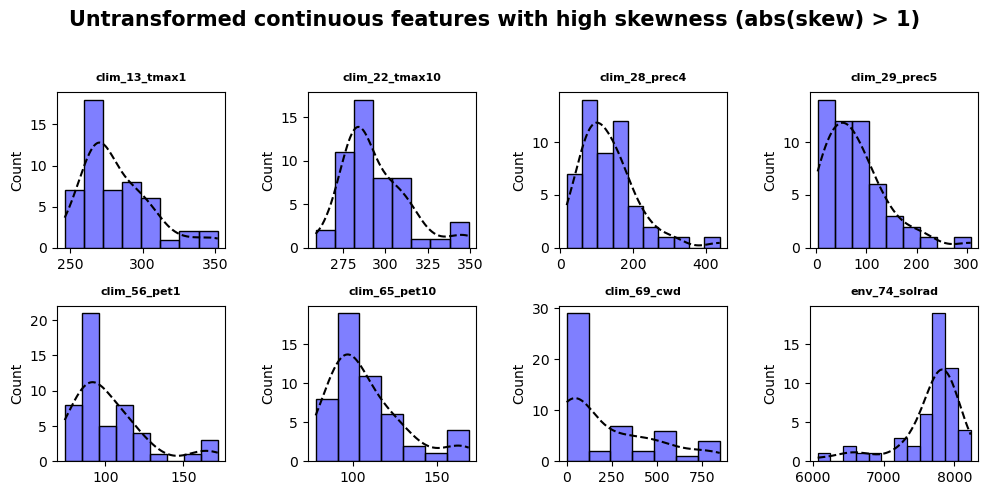

In [51]:
# plot highly skewed continuous features
plot_feats_distributions(
    data=X[highly_skewed_feats.index], 
    feats=highly_skewed_feats.index, 
    figsize=(10, 5), 
    nrows=2,
    ncols=4, 
    main_title="Untransformed continuous features with high skewness (abs(skew) > 1)"
)

Check if some features contain zero values

In [52]:
(X[highly_skewed_feats.index] == 0).sum()[(X[highly_skewed_feats.index] == 0).sum() > 0]

clim_69_cwd_Annual climatic water deficit (mm)    2
dtype: int64

So we have a feature with zero values. We will sqrt-transformed this feature and will use log-transform for the rest of the highly skewed features

In [53]:
highskew_sqrt_transf_feats = list((X[highly_skewed_feats.index] == 0).sum()[(X[highly_skewed_feats.index] == 0).sum() > 0].index)
highskew_log_transf_feats = [feat for feat in highly_skewed_feats.index if feat not in highskew_sqrt_transf_feats]
print(f"sqrt-transformed feats: {highskew_sqrt_transf_feats}")
print(f"log-transformed feats: {highskew_log_transf_feats}")

sqrt-transformed feats: ['clim_69_cwd_Annual climatic water deficit (mm)']
log-transformed feats: ['clim_13_tmax1_Monthly maximum temperature - January (°C x 10)', 'clim_22_tmax10_Monthly maximum temperature - October (°C x 10)', 'clim_28_prec4_Monthly total precipitation - April (mm.month-1)', 'clim_29_prec5_Monthly total precipitation - May (mm.month-1)', 'clim_56_pet1_Monthly potential evapotranspiration from the Thornthwaite equation - January (mm.month-1)', 'clim_65_pet10_Monthly potential evapotranspiration from the Thornthwaite equation - October (mm.month-1)', 'env_74_solrad_Solar radiation; computed from altitude, slope and aspect (Wh.m-2.day-1)']


Visualize sqrt and log transformed features distributions

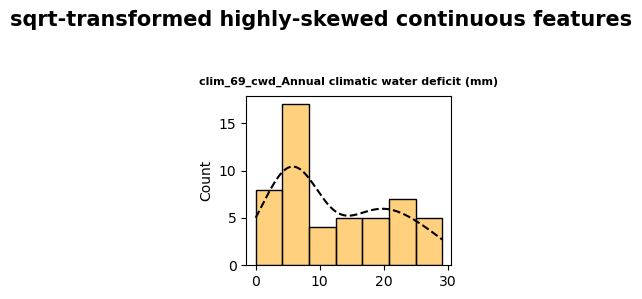

In [54]:
plot_feats_distributions(
    data=np.sqrt(X[highskew_sqrt_transf_feats]), 
    feats=highskew_sqrt_transf_feats, 
    figsize=(3, 3), 
    nrows=1,
    ncols=1, 
    barcolor="orange", 
    main_title="sqrt-transformed highly-skewed continuous features"
)

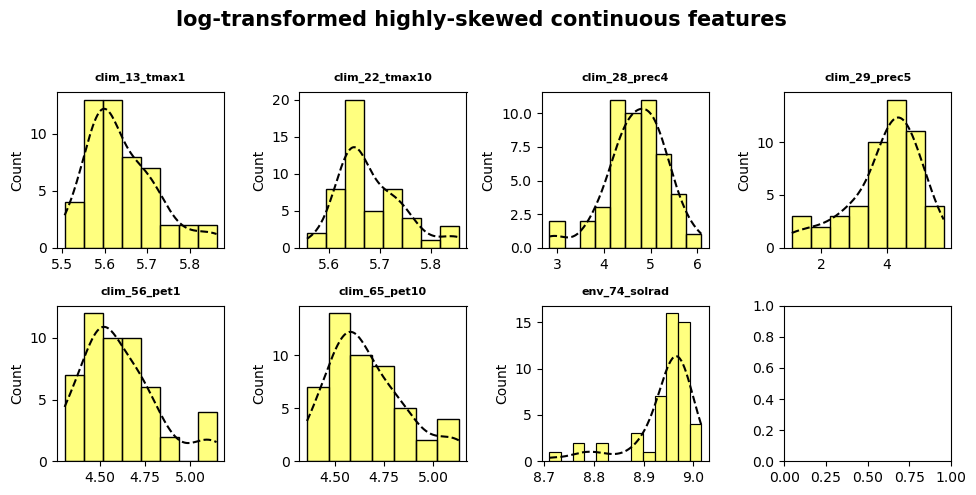

In [55]:
plot_feats_distributions(
    data=np.log(X[highskew_log_transf_feats]), feats=
    highskew_log_transf_feats, 
    figsize=(10, 5),
    nrows=2,
    ncols=4, 
    barcolor="yellow", 
    main_title="log-transformed highly-skewed continuous features"
)

In [56]:
# apply the transformations
X[highskew_sqrt_transf_feats] = X[highskew_sqrt_transf_feats].apply(np.sqrt)
X[highskew_log_transf_feats] = X[highskew_log_transf_feats].apply(np.log)
X[highskew_sqrt_transf_feats + highskew_log_transf_feats].head()

,clim_69_cwd_Annual climatic water deficit (mm),clim_13_tmax1_Monthly maximum temperature - January (°C x 10),clim_22_tmax10_Monthly maximum temperature - October (°C x 10),clim_28_prec4_Monthly total precipitation - April (mm.month-1),clim_29_prec5_Monthly total precipitation - May (mm.month-1),clim_56_pet1_Monthly potential evapotranspiration from the Thornthwaite equation - January (mm.month-1),clim_65_pet10_Monthly potential evapotranspiration from the Thornthwaite equation - October (mm.month-1),"env_74_solrad_Solar radiation; computed from altitude, slope and aspect (Wh.m-2.day-1)"
0,8.774964,5.620401,5.655992,4.290459,4.158883,4.521789,4.521789,8.775704
1,4.000000,5.572154,5.638355,5.170484,4.779123,4.418841,4.521789,8.973858
2,29.137605,5.786897,5.789960,4.204693,1.609438,5.087596,5.099866,8.959826
3,22.383029,5.726848,5.752573,4.762174,3.583519,4.844187,4.919981,8.984568
4,22.068076,5.710427,5.736572,4.718499,3.496508,4.795791,4.867534,8.994172


In [57]:
# Concat transformed to original imputed gdf
gdf_coffea_imputed_transformed = pd.concat([
    gdf_coffea_imputed.drop(columns=features_cont+features_categ), 
    X, 
    gdf_coffea_imputed[features_categ]
], axis=1)


In [58]:
assert gdf_coffea_imputed_transformed.shape == gdf_coffea_imputed.shape
if list(gdf_coffea_imputed_transformed.columns) == list(gdf_coffea_imputed.columns):
    print("OK")

OK


In [59]:
gdf_coffea_imputed_transformed.head()

,specimen_id,longitude,latitude,mada_geom_point,species_name,genome_size_2C_pg,clim_1_tmin1_Monthly minimum temperature - January (°C x 10),clim_2_tmin2_Monthly minimum temperature - February (°C x 10),clim_3_tmin3_Monthly minimum temperature - March (°C x 10),clim_4_tmin4_Monthly minimum temperature - April (°C x 10),...,env_78_wat_Watersheds_RetDisp_Mahavavy,env_78_wat_Watersheds_RetDisp_Manampatrana,env_78_wat_Watersheds_RetDisp_Mananara_du_Sud,env_78_wat_Watersheds_RetDisp_Mandrare,env_78_wat_Watersheds_RetDisp_Mangoky,env_78_wat_Watersheds_RetDisp_Mangoro,env_78_wat_Watersheds_RetDisp_Onilahy,env_78_wat_Watersheds_RetDisp_Sambirano,env_78_wat_Watersheds_RetDisp_Tsiribihina,env_78_wat_Watersheds__nodata
0,ABA,46.862400,-24.754100,POINT (688328.240 7260998.023),C.abbayesii,1.25,155.0,195.0,188.0,171.0,...,0,0,0,0,0,0,0,0,0,0
1,AMB,48.943300,-18.452200,POINT (916635.952 7955240.629),C.ambodirianenis,1.27,157.0,203.0,199.0,185.0,...,0,0,0,0,0,0,0,0,0,0
2,AMBON,46.419806,-15.574583,POINT (652237.905 8277614.406),C.ambongensis,1.16,222.0,236.0,238.0,235.0,...,0,0,0,0,0,0,0,0,0,0
3,ANK1,49.543300,-12.949100,POINT (993250.150 8564104.062),C.ankaranensis,1.17,206.0,228.0,227.0,224.0,...,0,0,0,0,0,0,0,0,0,0
4,ANK2,49.543300,-12.849100,POINT (993446.882 8575194.181),C.ankaranensis,1.17,203.0,226.0,224.0,222.0,...,0,0,0,0,0,0,0,0,0,0


## Feature selection for botanical_series classification task

Considering we have both continuous and categorical data, we will perform different Feature Selection (FS) techniques and determine the best performing FS technique.

**Baseline filter method**:
1. Low variance threshold (An Introduction to Variable and Feature Selection, 2003)

**Univariate Simple collinearity and multicollinearity pipeline**:
1. Eliminate 1 feature from highly correlated pairs (pearson)
2. VIF threshold of 10 for continuous features previously reduced by PCA for similar/relevant categories
3. Chi-Squared test for categ feats with select best k (only categorical, non-ordinal features)

**Univariate filter method pipeline (sklearn docs)**: (Feature Selection for Classification: A Review. MSU 2014)
1. Categorical features custom filter:
    - Chi-squared test
    - mutual_info test
    - CustomFeatureSelector that combines x2-mi

2. Continuous features custom filter:
    - F_test selection (linear)
    - mutual_info (both lin/non-lin)
    - CustomFeatureSelector that combines F_test and MI

3. Find the best k for each FS filter test


**Wrapper methods**:
- Forward Sequential Feature Selection (D. Ververidis and C. Kotropoulos, "Sequential forward feature selection with low computational cost," 2005)
- Recursive Feature Elimination (X. Zeng, Y. -W. Chen and C. Tao, "Feature Selection Using Recursive Feature Elimination for Handwritten Digit Recognition," 2009)
- *Exhausitive feature selection* Not sure yet, might be too computationaly expansive since it is a brute-force approach

**Embedded methods**:
- L1-based feature selection (LASSO: A feature selection technique in predictive modeling for machine learning, Rohini 2016)
- RandomForest Importance (Rogers, J., Gunn, S. (2006). Identifying Feature Relevance Using a Random Forest.)

**Dimensionality Reduction method**:
- PCA and MCA on whole feature set (F. Song, Z. Guo and D. Mei, "Feature Selection Using Principal Component Analysis," 2010)
- KernelPCA / Kernel Trick (Q. K. Weinberger, F. Sha and K. L. Saul, "Learning a kernel matrix for nonlinear dimensionality reduction",)

**Feature engineering pipelines**:
1. Reduce features with domain knowledge and submodels (sine-cosine for monthly events)
2. PCA and MCA on common information features
3. Combine either method 1) or 2) with some filter methods

**Bio-inspired algorithms**:
- Particle Swarm Optimization (PSO) ( J. Kennedy and R. Eberhart, "Particle swarm optimization")
- Genetic Algo (GA) (Goldberg D (1989) Genetic algorithm in search. Optimization and Machine Learning,)

### Baseline variance threshold method

#### Apply MinMax 0-1 scaling for continus features

In [60]:
# Assign imputed/transformed continuous features to X
X_cont = pd.DataFrame(gdf_coffea_imputed_transformed[features_cont])
X_cont.head()

,genome_size_2C_pg,clim_1_tmin1_Monthly minimum temperature - January (°C x 10),clim_2_tmin2_Monthly minimum temperature - February (°C x 10),clim_3_tmin3_Monthly minimum temperature - March (°C x 10),clim_4_tmin4_Monthly minimum temperature - April (°C x 10),clim_5_tmin5_Monthly minimum temperature - May (°C x 10),clim_6_tmin6_Monthly minimum temperature - June (°C x 10),clim_7_tmin7_Monthly minimum temperature - July (°C x 10),clim_8_tmin8_Monthly minimum temperature - August (°C x 10),clim_9_tmin9_Monthly minimum temperature - September (°C x 10),...,clim_66_pet11_Monthly potential evapotranspiration from the Thornthwaite equation - November (mm.month-1),clim_67_pet12_Monthly potential evapotranspiration from the Thornthwaite equation - December (mm.month-1),clim_68_pet_Annual potential evapotranspiration from the Thornthwaite equation (mm),clim_69_cwd_Annual climatic water deficit (mm),clim_70_ndm_Number of dry months in the year (months.year-1),env_71_alt_Altitude (meters),env_72_slo_Slope (degrees),env_73_asp_Aspect; clockwise from North (degrees),"env_74_solrad_Solar radiation; computed from altitude, slope and aspect (Wh.m-2.day-1)",env_79_forcov_Percentage of forest cover in 1 km by 1 km grid cells (%)
0,1.25,155.0,195.0,188.0,171.0,136.0,122.0,120.0,124.0,138.0,...,110.0,123.0,1022.0,8.774964,4.0,350.0,14.0,167.0,8.775704,100.0
1,1.27,157.0,203.0,199.0,185.0,164.0,149.0,142.0,139.0,144.0,...,109.0,121.0,1041.0,4.000000,1.0,567.0,8.0,27.0,8.973858,65.0
2,1.16,222.0,236.0,238.0,235.0,217.0,199.0,191.0,193.0,205.0,...,164.0,156.0,1709.0,29.137605,8.0,24.0,1.0,304.0,8.959826,44.0
3,1.17,206.0,228.0,227.0,224.0,211.0,192.0,186.0,188.0,194.0,...,147.0,146.0,1482.0,22.383029,8.0,158.0,12.0,42.0,8.984568,20.0
4,1.17,203.0,226.0,224.0,222.0,209.0,190.0,184.0,186.0,192.0,...,141.0,141.0,1431.0,22.068076,8.0,137.0,6.0,355.0,8.994172,0.0


In [61]:
scaler = MinMaxScaler()
X_cont_scaled = pd.DataFrame(scaler.fit_transform(X_cont), columns=X_cont.columns, index=X_cont.index)
X_cont_scaled.head()

,genome_size_2C_pg,clim_1_tmin1_Monthly minimum temperature - January (°C x 10),clim_2_tmin2_Monthly minimum temperature - February (°C x 10),clim_3_tmin3_Monthly minimum temperature - March (°C x 10),clim_4_tmin4_Monthly minimum temperature - April (°C x 10),clim_5_tmin5_Monthly minimum temperature - May (°C x 10),clim_6_tmin6_Monthly minimum temperature - June (°C x 10),clim_7_tmin7_Monthly minimum temperature - July (°C x 10),clim_8_tmin8_Monthly minimum temperature - August (°C x 10),clim_9_tmin9_Monthly minimum temperature - September (°C x 10),...,clim_66_pet11_Monthly potential evapotranspiration from the Thornthwaite equation - November (mm.month-1),clim_67_pet12_Monthly potential evapotranspiration from the Thornthwaite equation - December (mm.month-1),clim_68_pet_Annual potential evapotranspiration from the Thornthwaite equation (mm),clim_69_cwd_Annual climatic water deficit (mm),clim_70_ndm_Number of dry months in the year (months.year-1),env_71_alt_Altitude (meters),env_72_slo_Slope (degrees),env_73_asp_Aspect; clockwise from North (degrees),"env_74_solrad_Solar radiation; computed from altitude, slope and aspect (Wh.m-2.day-1)",env_79_forcov_Percentage of forest cover in 1 km by 1 km grid cells (%)
0,0.636364,0.31,0.417722,0.376471,0.285714,0.156522,0.190083,0.232759,0.273504,0.296296,...,0.298701,0.447761,0.232402,0.301156,0.363636,0.307143,0.481481,0.462857,0.212084,1.00
1,0.681818,0.33,0.518987,0.505882,0.428571,0.400000,0.413223,0.422414,0.401709,0.351852,...,0.285714,0.417910,0.253631,0.137280,0.090909,0.500893,0.259259,0.062857,0.862733,0.65
2,0.431818,0.98,0.936709,0.964706,0.938776,0.860870,0.826446,0.844828,0.863248,0.916667,...,1.000000,0.940299,1.000000,1.000000,0.727273,0.016071,0.000000,0.854286,0.816656,0.44
3,0.454545,0.82,0.835443,0.835294,0.826531,0.808696,0.768595,0.801724,0.820513,0.814815,...,0.779221,0.791045,0.746369,0.768184,0.727273,0.135714,0.407407,0.105714,0.897900,0.20
4,0.454545,0.79,0.810127,0.800000,0.806122,0.791304,0.752066,0.784483,0.803419,0.796296,...,0.701299,0.716418,0.689385,0.757374,0.727273,0.116964,0.185185,1.000000,0.929435,0.00


Separating the categorical features df

In [62]:
X_cat = pd.DataFrame(gdf_coffea_imputed_transformed[features_categ])
X_cat.head()

,env_75_geo_Rock types_Alluvial_&_Lake_deposits,env_75_geo_Rock types_Basement_Rocks_(Ign_&_Met),env_75_geo_Rock types_Lavas_(including_Basalts_&_Gabbros),env_75_geo_Rock types_Mangrove_Swamp,env_75_geo_Rock types_Marble_(Cipolin),"env_75_geo_Rock types_Mesozoic_Limestones_+_Marls_(inc._""Tsingy"")",env_75_geo_Rock types_Quartzites,env_75_geo_Rock types_Sandstones,env_75_geo_Rock types_Tertiary_Limestones_+_Marls_&_Chalks,env_75_geo_Rock types_Ultrabasics,...,env_78_wat_Watersheds_RetDisp_Mahavavy,env_78_wat_Watersheds_RetDisp_Manampatrana,env_78_wat_Watersheds_RetDisp_Mananara_du_Sud,env_78_wat_Watersheds_RetDisp_Mandrare,env_78_wat_Watersheds_RetDisp_Mangoky,env_78_wat_Watersheds_RetDisp_Mangoro,env_78_wat_Watersheds_RetDisp_Onilahy,env_78_wat_Watersheds_RetDisp_Sambirano,env_78_wat_Watersheds_RetDisp_Tsiribihina,env_78_wat_Watersheds__nodata
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Baseline feature selection based on variance threshold for continuous features

Since we have 0 features with missing data, no need to drop any feature in terms of missing value ratio 

In [63]:
def variance_threshold_fs(
        X: pd.DataFrame,
        variance_thresholds: Optional[Union[int, list[Union[int, float]], np.array]] = None,
    ) -> Union[np.array, dict[int, np.array]]:
    
    #TODO CHECK FOR VARIANCE THRESHOLDS
    try:
        variance_thresholds = int(variance_thresholds)
    except:
        pass
    if isinstance(variance_thresholds, int):
        variance_thresholds = [variance_thresholds]
    elif variance_thresholds is None:
        variance_thresholds = np.linspace(0, 0.05, 21)
    

    # Get the features that fall below a given variance threshold
    fs_var_threshholds = {}

    for var_thresh in variance_thresholds:
        selector = VarianceThreshold(threshold=var_thresh)
        selector.fit(X)
        mask = np.ones(len(X.columns), dtype=bool)
        mask[selector.get_support()] = False
        fs_var_threshholds[var_thresh] = np.array(X.columns)[mask]
    
    if len(variance_thresholds) == 1:
        return fs_var_threshholds[variance_thresholds[0]]
    else:
        return fs_var_threshholds

In [64]:
fs_var_thresh = variance_threshold_fs(X=X_cont_scaled)

# Print only var_thresh/features combination with values
count = 0
for var_thresh, features in fs_var_thresh.items():
    if len(features) > 0:
        print(f"{var_thresh}: {fs_var_thresh[var_thresh]}\n")
        count += 1
    if count == 2:
        break

0.0375: ['clim_28_prec4_Monthly total precipitation - April (mm.month-1)']

0.04: ['clim_28_prec4_Monthly total precipitation - April (mm.month-1)'
 'clim_41_bio5_Max temperature of warmest month (degrees)']



Let's visualize see how features with the lowest variance look on a distribution plot

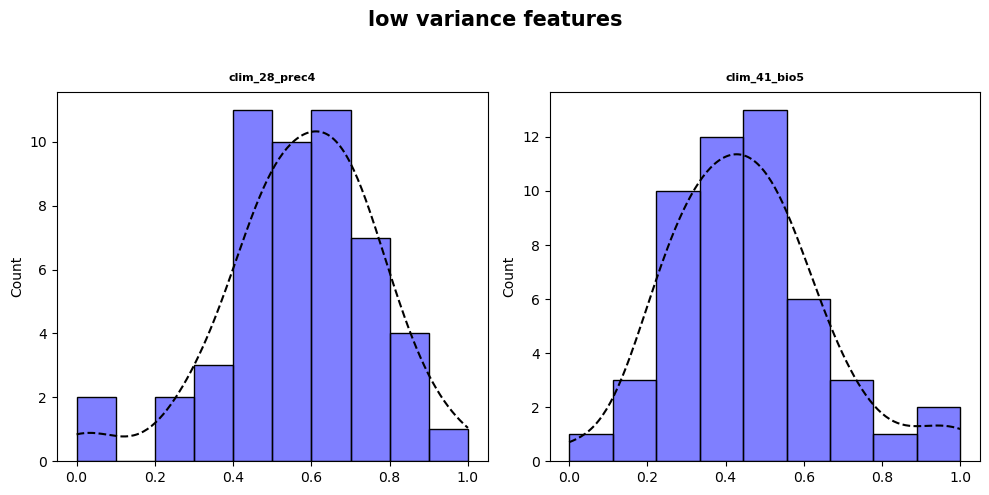

In [65]:
low_var_features = fs_var_thresh[0.04]
low_var_features
plot_feats_distributions(
    data=X_cont_scaled, 
    feats=low_var_features, 
    nrows=1, 
    ncols=len(low_var_features), 
    figsize=(10, 5), main_title="low variance features"
)

Still some variance is present, it looks like a normal distribution so we can't filter any out

#### Baseline feature selection based on variance threshold for categorical features

In [66]:
zero_var_categ_feats = variance_threshold_fs(X=X_cat, variance_thresholds=0)
print(
    f"There are {len(zero_var_categ_feats)} features with 0 variance (same values) "
    f"out of all {len(features_categ)} categorical features")

There are 36 features with 0 variance (same values) out of all 83 categorical features


In [67]:
# Replace categorical df with non-zero variance features
X_cat = X_cat.drop(columns=zero_var_categ_feats)
features_categ = [feat for feat in features_categ if feat not in zero_var_categ_feats]

In [68]:
round(np.sqrt(len(features_categ)))

7

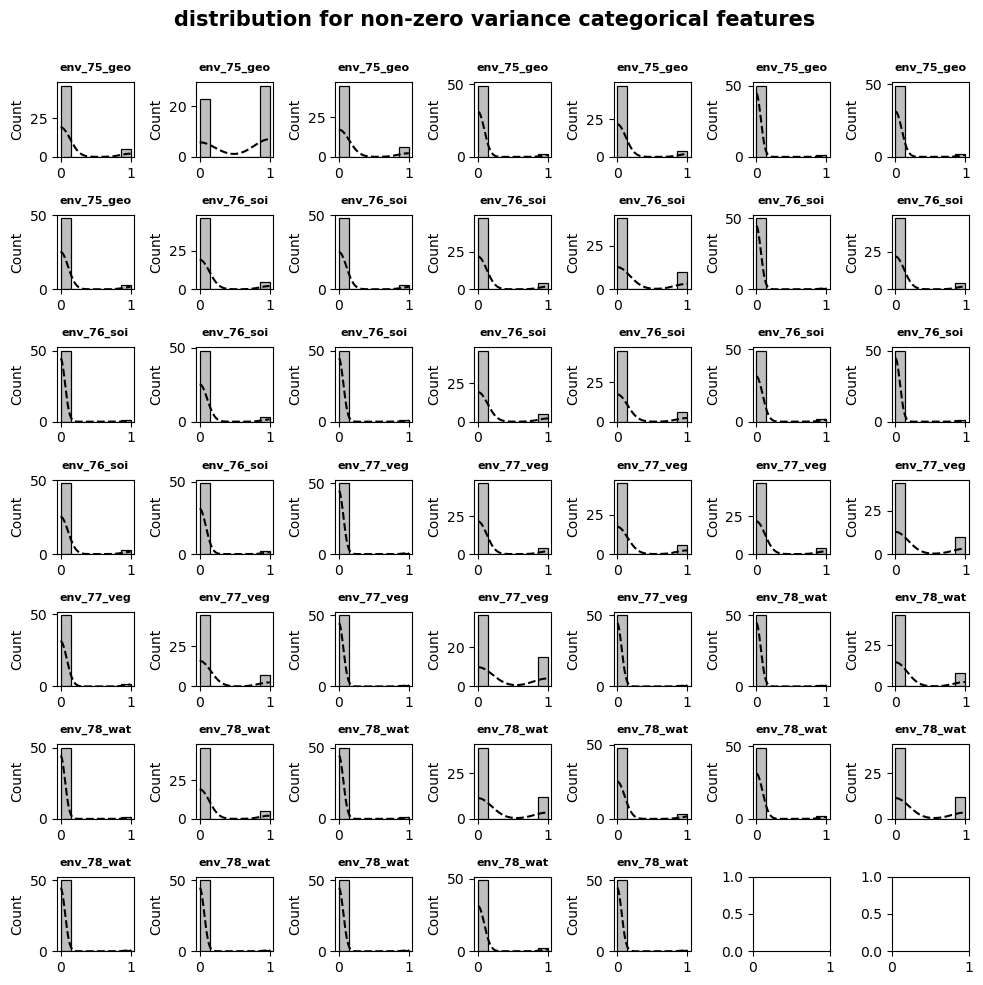

In [69]:
plot_feats_distributions(
    data=X_cat,
    feats=features_categ,
    nrows=round(np.sqrt(len(features_categ))),
    ncols=round(np.sqrt(len(features_categ))),
    main_title="distribution for non-zero variance categorical features",
    barcolor="grey"
)

### Univariate Simple collinearity and multicollinearity pipeline 

Litterature on feature correlation
- "Correlation-based feature selection for machine learning" by Mark A. Hall (1999): This is a thesis document rather than a research paper, but it does cover correlation-based feature selection in detail.

- "Feature selection: A data perspective" by Chandrashekar & Sahin (2014): This review paper covers various feature selection techniques, including correlation-based feature selection.

- "An introduction to variable and feature selection" by Guyon & Elisseeff (2003): This paper presents a broad overview of feature selection techniques, including methods for removing redundant features.

- "A survey on feature selection methods" by Dash & Liu (1997): This is an older survey, but it gives an overview of feature selection methods including those based on correlations.

#### Pearson coefficient scores between continuous variables

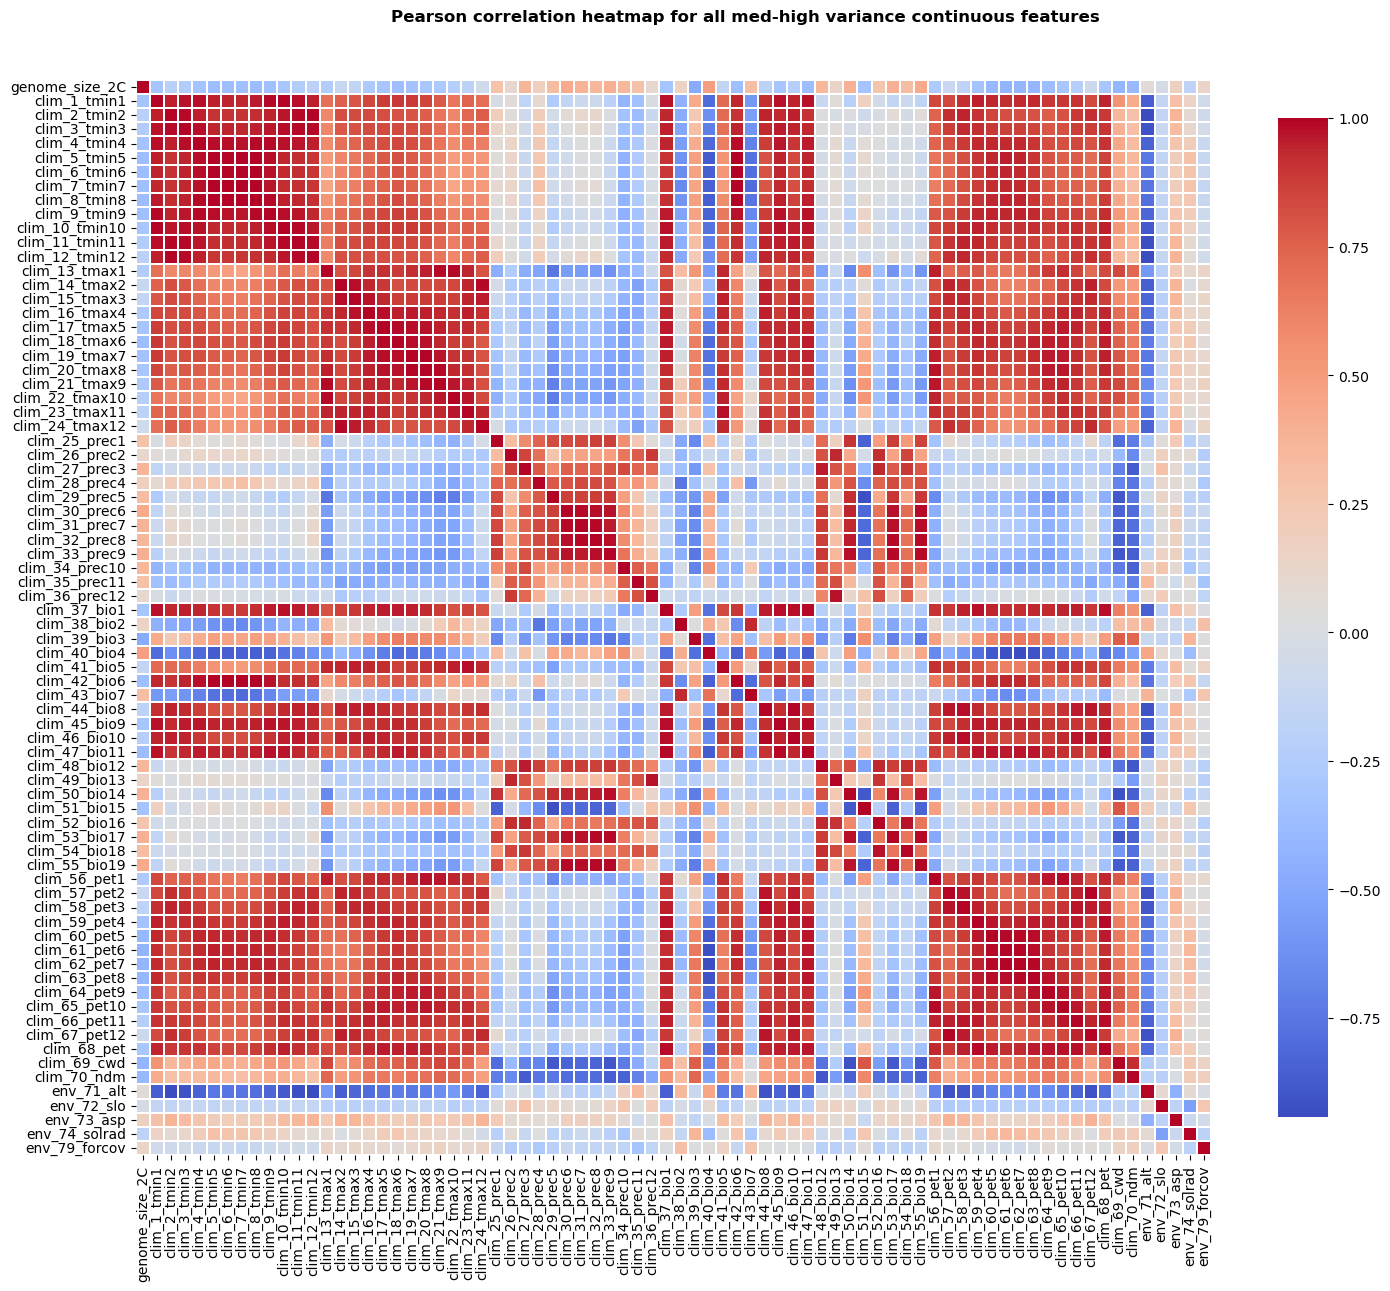

In [74]:
fig, ax = plt.subplots(figsize=(15, 15))

sns.heatmap(
    data=X_cont_scaled.corr(), 
    cmap="coolwarm",
    linewidths=0.1,
    square=True,
    yticklabels=["_".join(label.split("_", 3)[:3]) for label in X_cont_scaled.columns],
    xticklabels=["_".join(label.split("_", 3)[:3]) for label in X_cont_scaled.columns],
    cbar_kws={"shrink": .70},
    ax=ax
)
fig.suptitle(f"Pearson correlation heatmap for all med-high variance continuous features", y=0.9, weight="bold")
fig.tight_layout()

Filtering out multiple thresholds

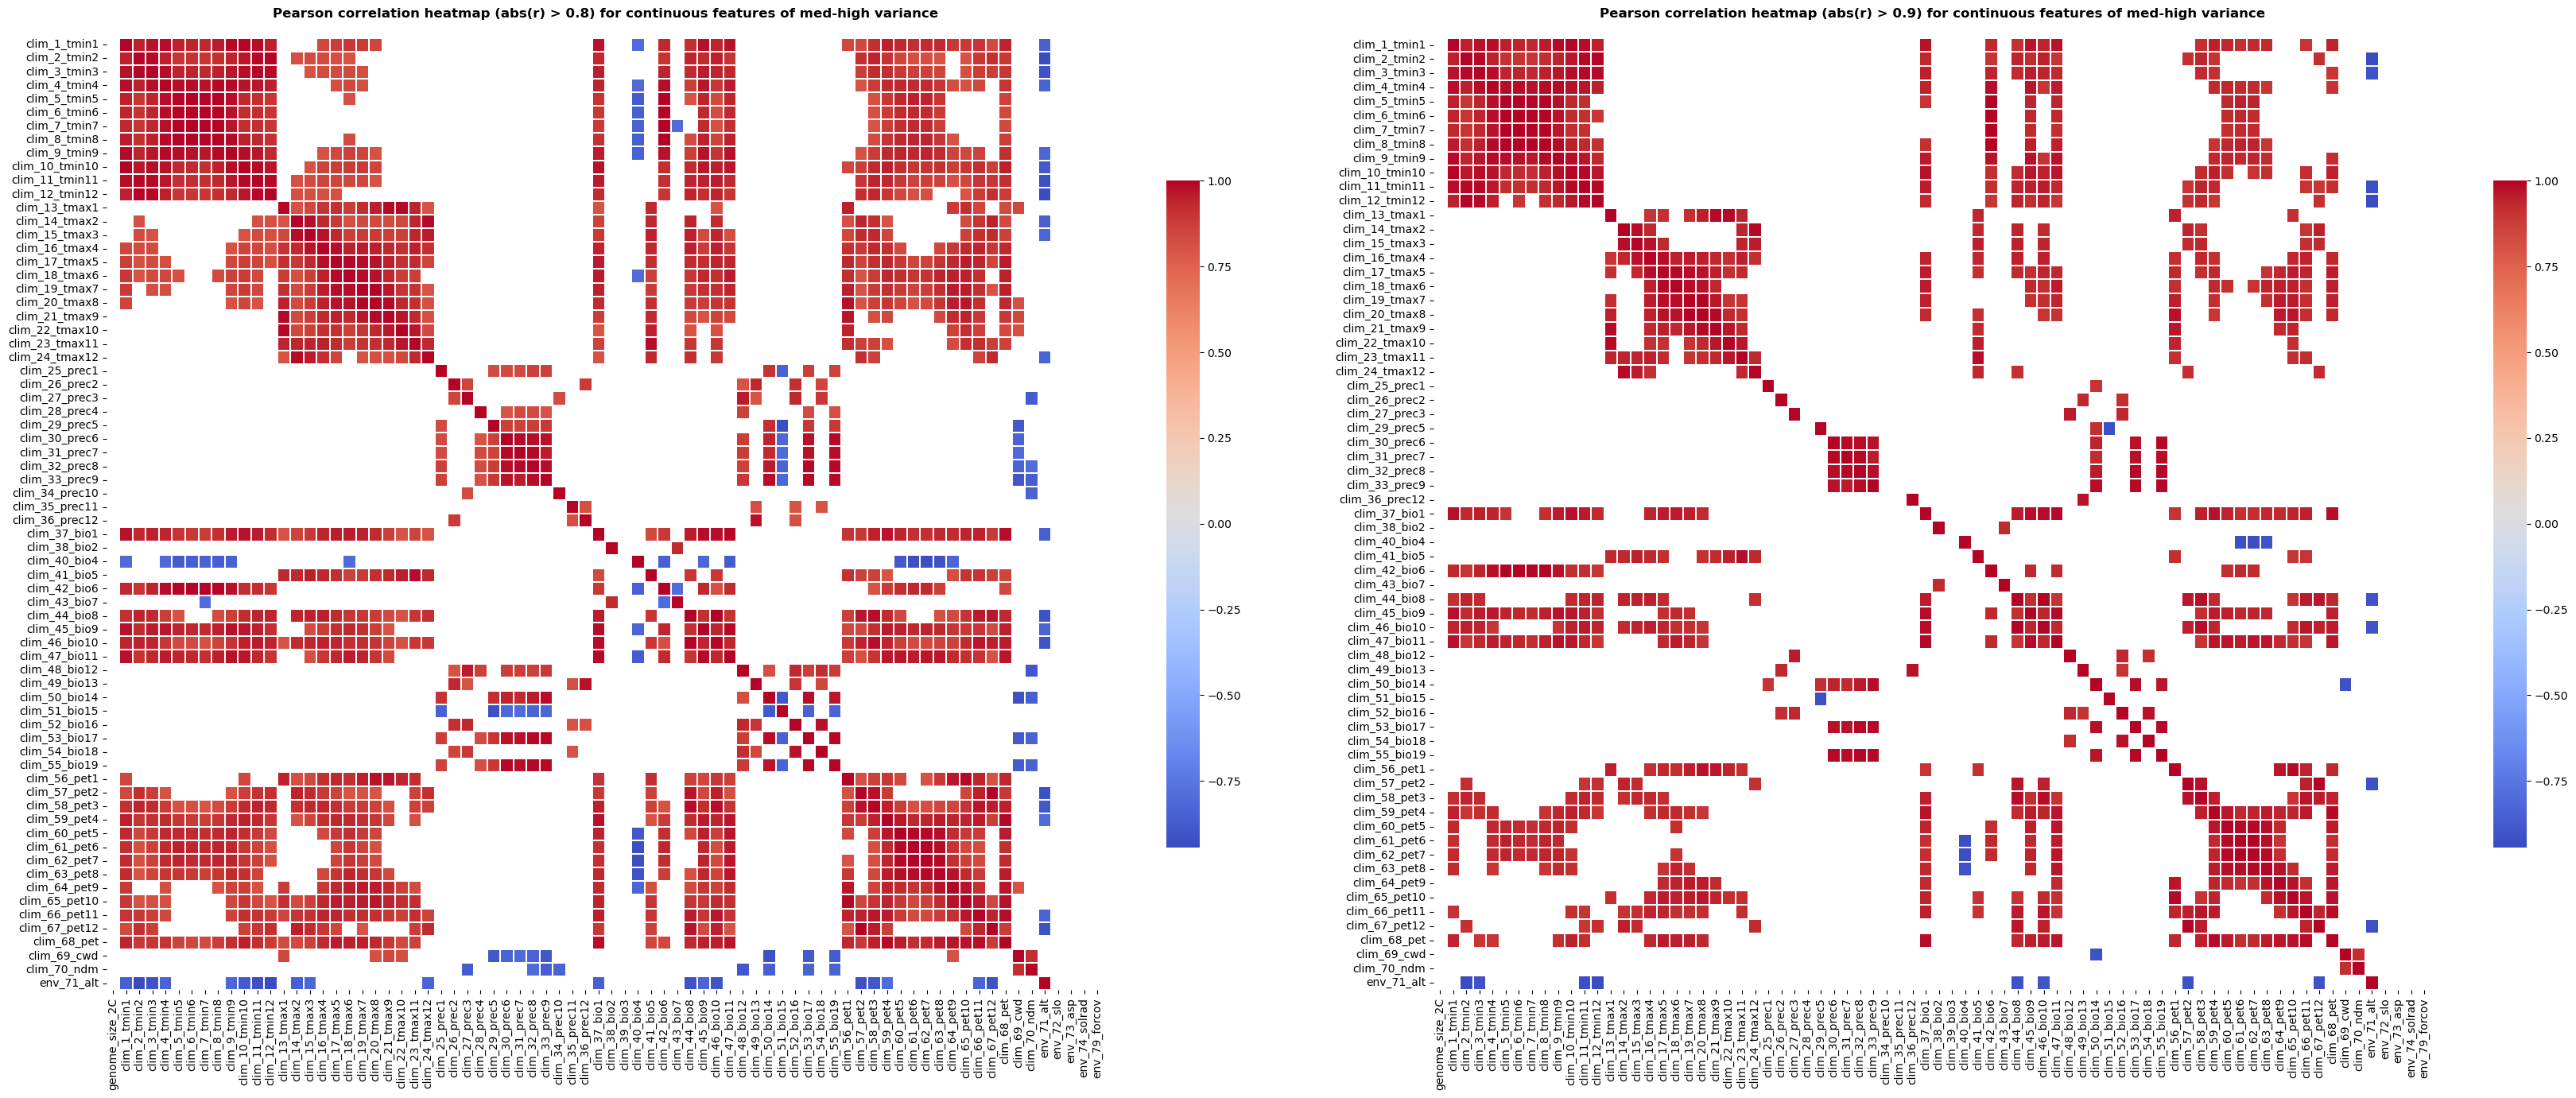

In [75]:
# Filtering for multiple thresholds
corr_thresholds = [0.8, 0.9]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(35, 15))
axes = axes.ravel()

for i, corr_threshold in enumerate(corr_thresholds):
    sns.heatmap(
        data=X_cont_scaled.corr()[abs(X_cont_scaled.corr()) > corr_threshold].dropna(thresh=2), 
        cmap="coolwarm",
        linewidths=0.1,
        yticklabels=["_".join(label.split("_", 3)[:3]) for label in X_cont_scaled.corr()[abs(X_cont_scaled.corr()) > corr_threshold].dropna(thresh=2).index],
        xticklabels=["_".join(label.split("_", 3)[:3]) for label in X_cont_scaled.corr()[abs(X_cont_scaled.corr()) > corr_threshold].dropna(thresh=2).columns],
        cbar_kws={"shrink": .70},
        ax=axes[i]
    )
    axes[i].set_title(f"Pearson correlation heatmap (abs(r) > {corr_threshold}) for continuous features of med-high variance\n", weight="bold")

fig.tight_layout(pad=5)

We see that we have some 'blocks' (correlations with near neighbors) of correlation around *tmin monthly*, *tmax monthly*, *monthly prec*, *some bioclioms* and *monthly pet*

In [76]:
high_corr_num_feats = {}    # Greather than abs 0.9 correlation 

for feat_x, row in X_cont_scaled.corr()[abs(X_cont_scaled.corr()) > 0.90].iterrows():

    corr_scores = {}
    for feat_y, score in row.items():
        if not np.isnan(score) and score != 1:
            corr_scores[feat_y] = score
    if corr_scores:
        high_corr_num_feats[feat_x] = corr_scores

In [77]:
for feat, corr_feats in high_corr_num_feats.items():
    print(f"{'_'.join(feat.split('_', 3)[:3])} has {len(corr_feats)} highly correlated features")

clim_1_tmin1 has 25 highly correlated features
clim_2_tmin2 has 22 highly correlated features
clim_3_tmin3 has 21 highly correlated features
clim_4_tmin4 has 22 highly correlated features
clim_5_tmin5 has 17 highly correlated features
clim_6_tmin6 has 17 highly correlated features
clim_7_tmin7 has 16 highly correlated features
clim_8_tmin8 has 20 highly correlated features
clim_9_tmin9 has 22 highly correlated features
clim_10_tmin10 has 24 highly correlated features
clim_11_tmin11 has 24 highly correlated features
clim_12_tmin12 has 20 highly correlated features
clim_13_tmax1 has 10 highly correlated features
clim_14_tmax2 has 11 highly correlated features
clim_15_tmax3 has 12 highly correlated features
clim_16_tmax4 has 21 highly correlated features
clim_17_tmax5 has 23 highly correlated features
clim_18_tmax6 has 18 highly correlated features
clim_19_tmax7 has 19 highly correlated features
clim_20_tmax8 has 18 highly correlated features
clim_21_tmax9 has 12 highly correlated feature

In [78]:
# Only pairs of features with high correlation
feats_pairs = []
for feat, corr_feats in high_corr_num_feats.items():
    if len(corr_feats) == 1:
        print(
            f"{feat} ###-CORRELATES WITH-### "
            f"{list(corr_feats.keys())[0]}\n"
            f"(r = {list(corr_feats.values())[0]:.3f})\n"
        )
        if feat not in feats_pairs or list(corr_feats.keys())[0] not in feats_pairs:
            feats_pairs.append(feat)
            feats_pairs.append(list(corr_feats.keys())[0])

clim_25_prec1_Monthly total precipitation - January (mm.month-1) ###-CORRELATES WITH-### clim_50_bio14_Precipitation of driest month (mm)
(r = 0.903)

clim_36_prec12_Monthly total precipitation - December (mm.month-1) ###-CORRELATES WITH-### clim_49_bio13_Precipitation of wettest month (mm)
(r = 0.973)

clim_38_bio2_Mean diurnal range (mean of monthly max temp - monthy min temp) ###-CORRELATES WITH-### clim_43_bio7_Temperature annual range  = BIO5-BIO6 (degrees)
(r = 0.927)

clim_43_bio7_Temperature annual range  = BIO5-BIO6 (degrees) ###-CORRELATES WITH-### clim_38_bio2_Mean diurnal range (mean of monthly max temp - monthy min temp)
(r = 0.927)

clim_51_bio15_Precipitation seasonality (coefficient of variation) ###-CORRELATES WITH-### clim_29_prec5_Monthly total precipitation - May (mm.month-1)
(r = -0.920)

clim_70_ndm_Number of dry months in the year (months.year-1) ###-CORRELATES WITH-### clim_69_cwd_Annual climatic water deficit (mm)
(r = 0.921)



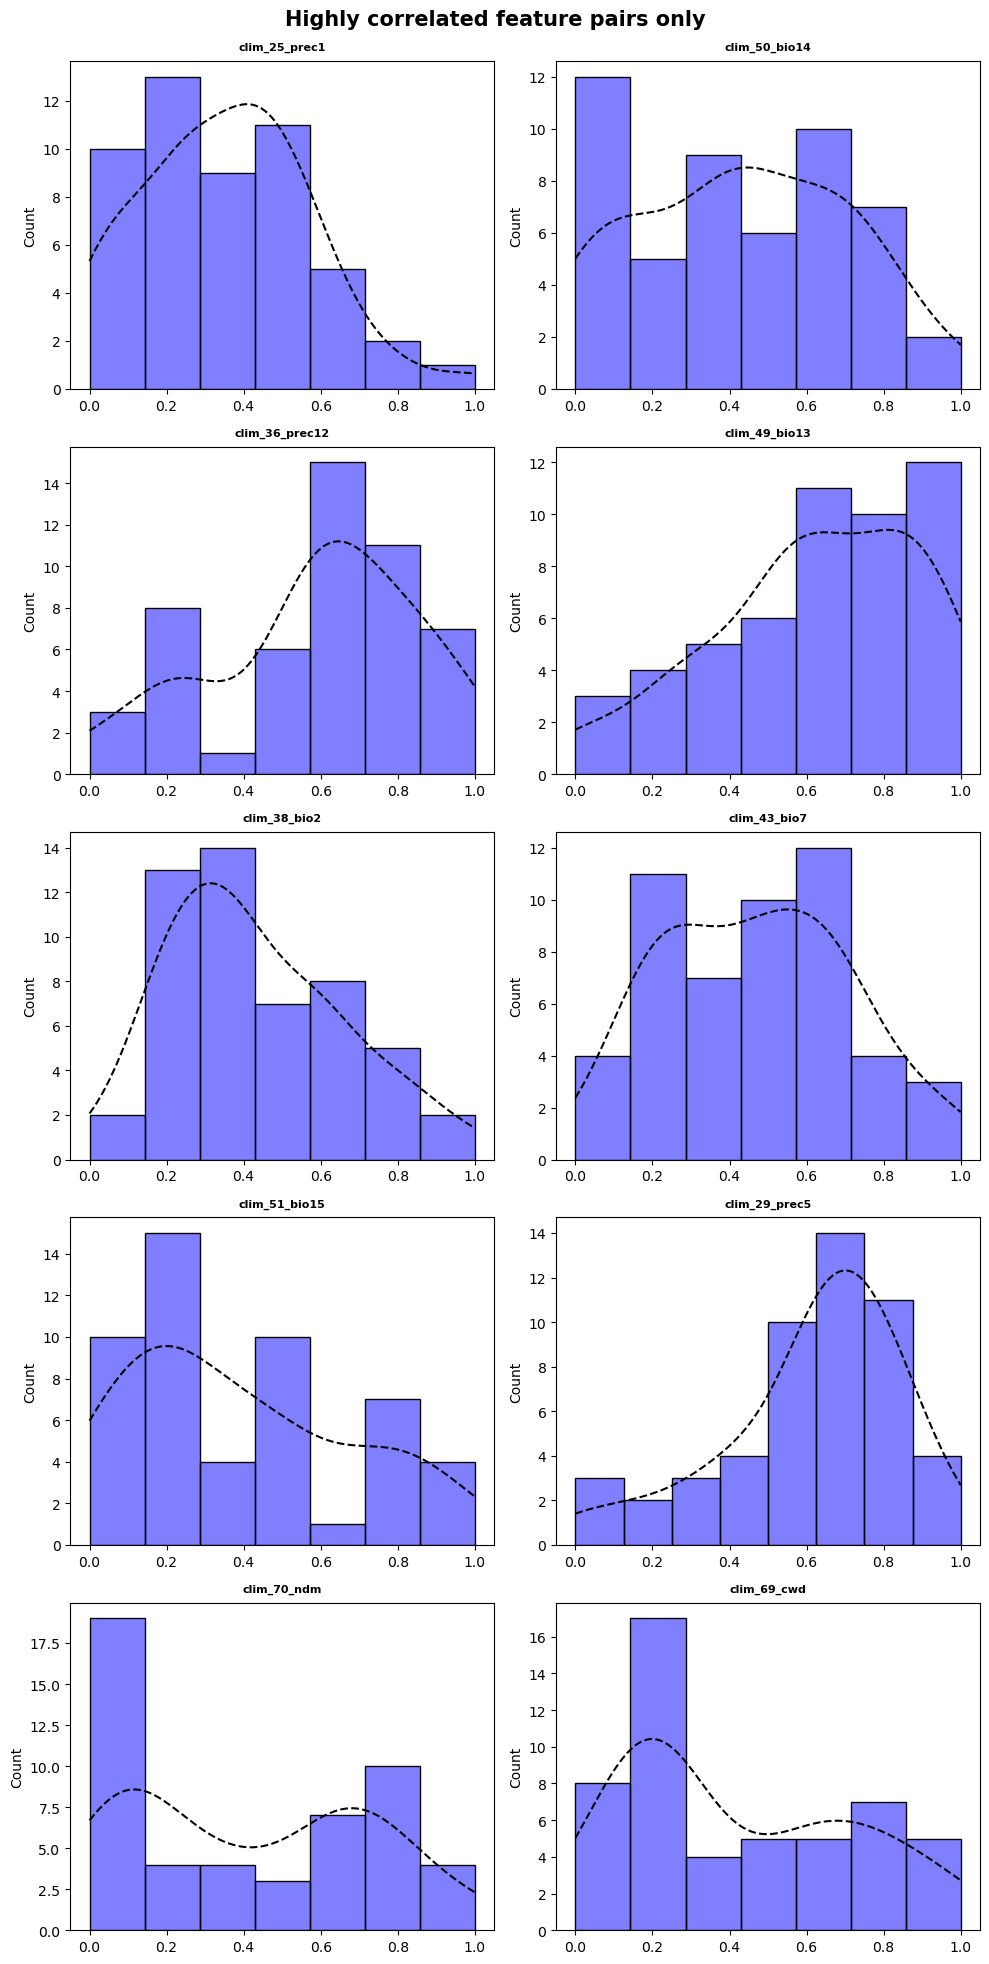

In [79]:
plot_feats_distributions(
    data=X_cont_scaled,
    feats=feats_pairs,
    nrows=int(len(feats_pairs)/2),
    ncols=2,
    main_title="Highly correlated feature pairs only",
    figsize=(10,20)
)

These variable pairs almost capture the same information for each pair. We could validate with climate experts but we can explain our choices:
- driest month is probably January for most of our specimens (keep driest month)
- wettest month probably December (keep wettest month)
- Diurnal range and annual range capture the same thing over different period (keep annual range since more normal/variance)
- Keep precipitation seasonality since it englobes a different variation (keep CV) since more variance
- Both num dry months and water deficit captures the same thing (since other precipitation data is present and both distrib look the same, keep num dry months )

In [80]:
feats_to_rm = [feat for feat in feats_pairs
 for layer_to_rm in ["clim_25", "clim_36", "clim_38", "clim_29", "clim_69"] 
 if layer_to_rm in feat]


Create a new X df for this feature selection pipeline

In [81]:
X_simple_corr_fs = X_cont.drop(columns=feats_to_rm)    # Revert MinMax scaling

#### Variance Inflation Factor thresholding

In [82]:
# Create a VIF dataframe with continuous features
vif_df = pd.DataFrame()
vif_df["continuous_features"] = X_simple_corr_fs.columns

In [83]:
vif_df["VIF"] = [variance_inflation_factor(X_simple_corr_fs.values, i)
                 for i in range(len(X_simple_corr_fs.columns))]

/home/local/USHERBROOKE/lals2906/anaconda3/envs/aphylo_cm/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [84]:
vif_df["VIF"].value_counts()

inf           70
419.080992     1
Name: VIF, dtype: int64

Since we have a lot of multicollinearity between the features, we will need to do some reduction and then retest the VIF

Before we can effectively perform PCA, it's generally recommended to standardize the data. Standardizing the data means subtracting the mean and scaling to unit variance. This is important because PCA is sensitive to the variances of the features. Features with larger variances will dominate the first principal components. Therefore, by standardizing, we ensure that all features are equally considered when performing the reduction, regardless of their original scales. It's particularly crucial when the dataset contains features of different scales and units.

**Scaling and PCA**

We will group the monthly features that are linked together and reduce them to the lowest amount of PCs we can and then rerun the VIF test

In [85]:
features_cont

['genome_size_2C_pg',
 'clim_1_tmin1_Monthly minimum temperature - January (°C x 10)',
 'clim_2_tmin2_Monthly minimum temperature - February (°C x 10)',
 'clim_3_tmin3_Monthly minimum temperature - March (°C x 10)',
 'clim_4_tmin4_Monthly minimum temperature - April (°C x 10)',
 'clim_5_tmin5_Monthly minimum temperature - May (°C x 10)',
 'clim_6_tmin6_Monthly minimum temperature - June (°C x 10)',
 'clim_7_tmin7_Monthly minimum temperature - July (°C x 10)',
 'clim_8_tmin8_Monthly minimum temperature - August (°C x 10)',
 'clim_9_tmin9_Monthly minimum temperature - September (°C x 10)',
 'clim_10_tmin10_Monthly minimum temperature - October (°C x 10)',
 'clim_11_tmin11_Monthly minimum temperature - November (°C x 10)',
 'clim_12_tmin12_Monthly minimum temperature - December (°C x 10)',
 'clim_13_tmax1_Monthly maximum temperature - January (°C x 10)',
 'clim_14_tmax2_Monthly maximum temperature - February (°C x 10)',
 'clim_15_tmax3_Monthly maximum temperature - March (°C x 10)',
 'cli

In [86]:
def extract_monthly_features(features: list, feats_to_rm: Optional[list]=None) -> dict[str, list]:
    """
    Extracts and categorizes monthly features from a given list of feature names.

    This function scans through the provided list of feature names and groups them
    based on patterns in their names. It supports grouping of 'tmin', 'tmax', 'prec', 
    and 'pet' type features. 

    Args:
        features (list): A list of feature names as strings.

    Returns:
        dict: A dictionary where keys are group labels ('tmin', 'tmax', 'prec', 'pet')
              and values are lists of feature names belonging to that group.

    """
    monthly_feats = {}
    monthly_patterns_labels = list(zip(
        [r"tmin\d+", r"tmax\d+", r"prec\d+", r"pet\d+"], 
        ["tmin", "tmax", "prec", "pet"]
        ))
   

    # Find all paterns in list ele
    for feat in features:
        for pattern_label in monthly_patterns_labels:
            if re.search(pattern_label[0], feat):
                # Create an empty container list first iteration
                if pattern_label[1] not in monthly_feats:
                    monthly_feats[pattern_label[1]] = []
                if feats_to_rm is None:
                    monthly_feats[pattern_label[1]] += [feat]    # Append the monthly list to proper key
                else:
                    monthly_feats[pattern_label[1]] += [feat] if feat not in feats_to_rm else []
    
    return monthly_feats


In [87]:
# Extract monhtly features names
monthly_feats = extract_monthly_features(features_cont, feats_to_rm)
X_simple_corr_fs[monthly_feats["tmin"]].head()


,clim_1_tmin1_Monthly minimum temperature - January (°C x 10),clim_2_tmin2_Monthly minimum temperature - February (°C x 10),clim_3_tmin3_Monthly minimum temperature - March (°C x 10),clim_4_tmin4_Monthly minimum temperature - April (°C x 10),clim_5_tmin5_Monthly minimum temperature - May (°C x 10),clim_6_tmin6_Monthly minimum temperature - June (°C x 10),clim_7_tmin7_Monthly minimum temperature - July (°C x 10),clim_8_tmin8_Monthly minimum temperature - August (°C x 10),clim_9_tmin9_Monthly minimum temperature - September (°C x 10),clim_10_tmin10_Monthly minimum temperature - October (°C x 10),clim_11_tmin11_Monthly minimum temperature - November (°C x 10),clim_12_tmin12_Monthly minimum temperature - December (°C x 10)
0,155.0,195.0,188.0,171.0,136.0,122.0,120.0,124.0,138.0,173.0,188.0,196.0
1,157.0,203.0,199.0,185.0,164.0,149.0,142.0,139.0,144.0,179.0,194.0,203.0
2,222.0,236.0,238.0,235.0,217.0,199.0,191.0,193.0,205.0,237.0,238.0,238.0
3,206.0,228.0,227.0,224.0,211.0,192.0,186.0,188.0,194.0,221.0,226.0,228.0
4,203.0,226.0,224.0,222.0,209.0,190.0,184.0,186.0,192.0,217.0,223.0,226.0


Perform PCA on the 4 subsets of features

In [88]:
def plot_explained_variance(data, n_components):
    # Calculate cumulated variance
    model = PCA(n_components=n_components)
    cumul = [0]
    tot = 0
    pca = model.fit(data)
    for i in pca.explained_variance_ratio_:
        cumul.append(i+tot)
        tot += i
    # Plot
    n_compo = np.arange(0, pca.n_components_+1)
    plt.figure()
    plt.plot(n_compo, cumul, marker="o")
    plt.axhline(y=n_components, color="black", linestyle="--" )
    plt.axhline(y=0.95, color="green", linestyle="-.")
    plt.xticks(n_compo)
    plt.xlabel("n_components")
    plt.ylabel("explained variance ratio")
    plt.legend([
        "Cumulative explained variance", 
        f"{n_components*100}% variance threshold",
        "95% variance threshold"
    ])
    #TODO NCOMPO 95% THRESHOLD CRITERION
    return pca

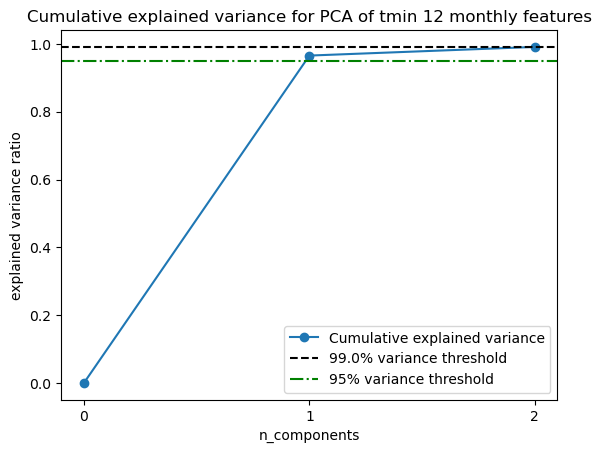

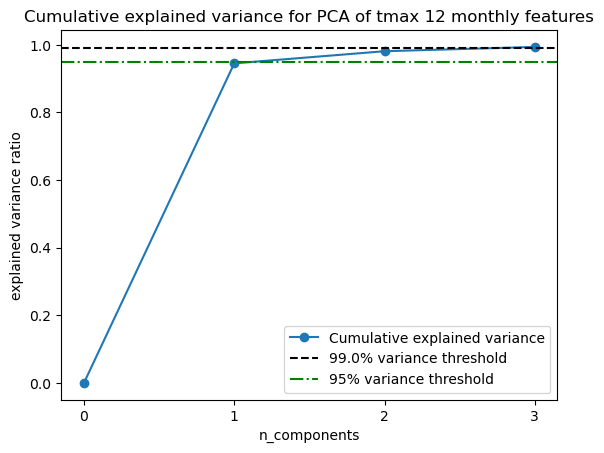

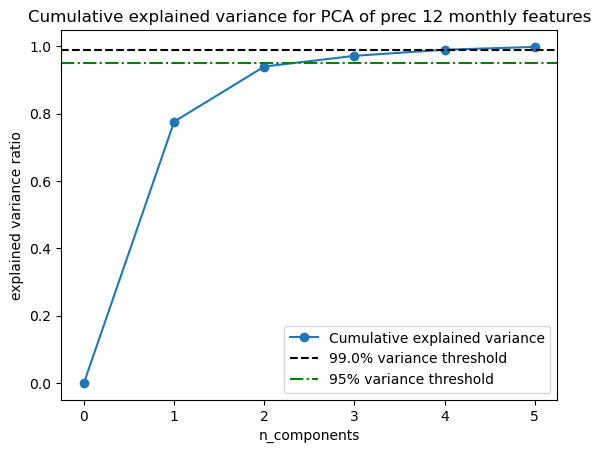

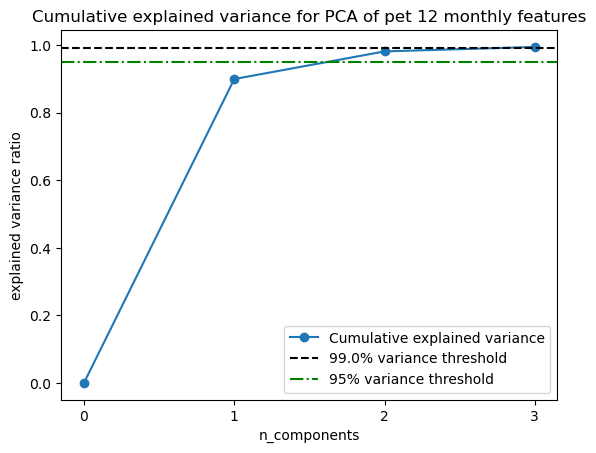

In [89]:
# Perform PCA on subset of monthly features
for feat in monthly_feats:
    plot_explained_variance(X_simple_corr_fs[monthly_feats[feat]], 0.99)
    plt.title(f"Cumulative explained variance for PCA of {feat} 12 monthly features")

---

PSEUDOCODE for filter method

In [90]:
# from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.pipeline import Pipeline, FeatureUnion
# from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
# from sklearn.preprocessing import StandardScaler, OneHotEncoder

# # Custom transformer to select a subset of the pandas dataframe
# class DataFrameSelector(BaseEstimator, TransformerMixin):
#     def __init__(self, attribute_names):
#         self.attribute_names = attribute_names
#     def fit(self, X, y=None):
#         return self
#     def transform(self, X):
#         return X[self.attribute_names].values

# # Lists of features
# categorical_features = ['...']  # List of categorical feature names
# continuous_features = ['...']  # List of continuous feature names

# # Pipelines for each kind of features
# categorical_pipeline = Pipeline([
#     ('selector', DataFrameSelector(categorical_features)),
#     ('one_hot', OneHotEncoder(sparse=False)),
#     ('chi2_selection', SelectKBest(chi2, k=10))  # Select 10 best features
# ])

# continuous_pipeline = Pipeline([
#     ('selector', DataFrameSelector(continuous_features)),
#     ('scaling', StandardScaler()),
#     ('f_test_selection', SelectKBest(f_classif, k=10)),  # Select 10 best features
#     ('mutual_info_selection', SelectKBest(mutual_info_classif, k=10))  # Select 10 best features
# ])

# # Full pipeline
# full_pipeline = FeatureUnion(transformer_list=[
#     ("categorical_pipeline", categorical_pipeline),
#     ("continuous_pipeline", continuous_pipeline),
# ])

# # Now you can fit and transform your data
# X_new = full_pipeline.fit_transform(X, y)


In [91]:
# class CustomFeatureSelector(BaseEstimator, TransformerMixin):
#     def __init__(self, k=10):
#         self.k = k  # Number of features to select
#         self.scores_ = None
#         self.feature_indices_ = None

#     def fit(self, X, y):
#         # Calculate F-test scores
#         f_test = SelectKBest(f_classif, k='all')
#         f_test.fit(X, y)
#         f_test_scores = f_test.scores_

#         # Calculate Mutual Information scores
#         mutual_info = SelectKBest(mutual_info_classif, k='all')
#         mutual_info.fit(X, y)
#         mutual_info_scores = mutual_info.scores_

#         # Calculate the combined score (for example, take the average)
#         self.scores_ = (f_test_scores + mutual_info_scores) / 2

#         # Select the top k feature indices
#         self.feature_indices_ = np.argsort(-self.scores_)[:self.k]
#         return self

#     def transform(self, X):
#         return X[:, self.feature_indices_]



In [92]:
# # Arrays to hold the results
# results = []
# k_values = list(range(1, 10))  # replace with your own range

# # Loop over all combinations of k
# for k_continuous in k_values:
#     for k_categorical in k_values:
#         # Build the preprocessing pipeline
#         continuous_pipeline = Pipeline([
#             ('selector', DataFrameSelector(continuous_features)),
#             ('scaling', StandardScaler()),
#             ('selection', CustomFeatureSelector(k=k_continuous))
#         ])
        
#         categorical_pipeline = Pipeline([
#             ('selector', DataFrameSelector(categorical_features)),
#             ('encoding', OneHotEncoder(handle_unknown='ignore')),
#             ('selection', SelectKBest(chi2, k=k_categorical))
#         ])
        
#         preprocessing = FeatureUnion([
#             ('continuous', continuous_pipeline),
#             ('categorical', categorical_pipeline)
#         ])

#         # Build the full pipeline
#         full_pipeline = Pipeline([
#             ('preprocessing', preprocessing),
#             ('classifier', your_classifier)  # replace with your classifierfeat
#         ])

#         # Fit and predict
#         full_pipeline.fit(X_train, y_train)
#         y_pred = full_pipeline.predict(X_test)

#         # Compute the performance metric
#         score = your_metric(y_test, y_pred)  # replace with your metric

#         # Store the result
#         results.append({
#             'k_continuous': k_continuous,
#             'k_categorical': k_categorical,
#             'score': score
#         })

# # Convert results to a DataFrame for easy viewing and manipulation
# results_df = pd.DataFrame(results)

# # Find the combination of k values that gives the highest score
# best_result = results_df.loc[results_df['score'].idxmax()]


## Feature selection (FS) for clustering task

Review on FS methods for unsupervised learning:

Solorio-Fernández, S., Carrasco-Ochoa, J. A., & Martínez-Trinidad, J. F. (2019). A review of unsupervised feature selection methods. Artificial Intelligence Review. doi:10.1007/s10462-019-09682-y 

Feature selection in a clustering unsupervised learning tasks is more challenging because we don't have a clear target variable to guide the process.

We will proceed with the following strategy in mind:

1. Remove feature with low variance (low information gain) for all

2. Then we will explore several approaches:



**Multivariate filter methods**:
- FSFS algo (Mitra PFSUFS, Ca M, Pal SK (2002) Unsupervised feature selection using feature similarity)
- RRFS (Relevance Redundancy Feature Selection) (Ferreira AJ, Figueiredo MA (2012) An unsupervised approach to feature discretization and selection.)

**Bio-inpired methods**:
- UFSACO (Unsupervised Feature Selection based on Ant Colony Optimization) (Tabakhi S, Moradi P, Akhlaghian F (2014) An unsupervised feature selection algorithm based on ant colony
optimization.)

**Spectral/Sparse learning methods**:
- LS: is the Laplacian Score ()
- SPEC: all the eigenvectors of the graph Laplacian ()

**Feature reduction methods**:
- PCA and MCA combination 

3. Evaluate the performance of the feature selection method on the following models using the Normalized Mutual Information (NMI) score:
- K-Means
- DB-Scan
- Hierarchical Algo
- Unsupervised random Forest (Afanador, N. L., Smolinska, A., Tran, T., and Blanchet, L. (2016) Unsupervised random forest: a tutorial with case studies. J. Chemometrics, 30: 231. doi: 10.1002/cem.2793. )